In [1]:
import pandas as pd
PATH = "rijs_iML1515_AMN.csv"
all_data = pd.read_csv(PATH, encoding="utf-8")
all_data_norm = (all_data - all_data.mean()) - all_data.std()
all_data

,EX_pi_e_i,EX_co2_e_i,EX_fe3_e_i,EX_h_e_i,EX_mn2_e_i,EX_fe2_e_i,EX_zn2_e_i,EX_mg2_e_i,EX_ca2_e_i,EX_ni2_e_i,...,PFK,PGI_for,PGK_rev,PGM_rev,PPC,PPCK,PTAr_for,PYK,SUCDi,TALA_for
0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,1.61,1.48,3.50,3.50,0.45,0.74,0.11,3.34,1.18,0.11
1,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,1.68,1.54,3.57,3.57,0.49,0.92,0.03,3.51,1.09,0.12
2,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,1.59,1.40,3.34,3.34,0.39,0.90,0.15,3.45,1.10,0.13
3,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,1.69,1.63,3.68,3.68,0.38,0.82,0.04,3.68,1.67,0.07
4,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,2.17,1.99,4.50,4.50,0.57,1.03,0.05,4.48,1.99,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,5.78,5.20,12.65,12.65,2.56,0.31,4.79,8.98,1.26,0.44
124,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,5.27,4.56,11.09,11.09,2.43,0.60,4.16,8.06,0.87,0.48
125,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,5.31,4.68,11.63,11.63,1.91,0.25,4.94,8.72,0.90,0.45
126,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,50.0,...,6.69,5.93,13.76,13.76,2.61,0.32,5.81,10.16,1.10,0.51


In [3]:
X = all_data_norm.iloc[:,:89].values
Y = all_data_norm.iloc[:,89:].values
print(X.shape, Y.shape)

(128, 89) (128, 31)


In [9]:
X = all_data.iloc[:,:89].values
Y = all_data.iloc[:,89:].values
print(X.shape, Y.shape)

(128, 89) (128, 31)


In [4]:
# XGBoost
# https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn
import xgboost as xgb # must be in AMN_windows env
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict as cvp
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.multioutput import MultiOutputRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, Tuple, List

In [10]:
LOO_split = int(Y.shape[0])

xgb_preds = []

for i in range(5):

    # XGBoost = xgb.XGBRegressor(n_estimators=600, max_depth=2, learning_rate=0.01, objective='reg:squarederror', random_state=i)
    multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))

    xgb_pred = cvp(multioutputregressor, X, Y, cv=KFold(n_splits=10, shuffle=True, random_state=i), n_jobs = 5)
    
    xgb_preds.append(xgb_pred)

In [11]:
mean_xgb_pred = np.array(xgb_preds).mean(axis=0)
std_xgb = np.array(xgb_preds).std(axis=0)

print(np.mean((mean_xgb_pred - Y)**2, axis=0)) # MSE between mean prediction (over 5 times 10-fold test sets) and true

print(r2_score(Y, mean_xgb_pred, multioutput='variance_weighted'))

[0.36414437 0.26729275 0.26729275 0.0020305  0.26729275 0.04075545
 0.04075545 1.32107715 0.27596246 0.26459655 0.41817853 0.3577907
 0.23367299 1.50588932 0.02451718 0.26333675 0.04568889 0.04568889
 0.23638242 0.03749946 0.77525177 0.3577907  0.30298501 1.50588932
 1.50588932 0.11690943 0.02717453 0.36414437 0.81343513 0.23367299
 0.00266307]
0.9100523319241323


In [14]:
mean_xgb_pred_df = pd.DataFrame(mean_xgb_pred, columns=all_data.iloc[:,89:].columns)
mean_xgb_pred_df

,ACKr_rev,ACONTa_for,ACONTb_for,BIOMASS_Ec_iML1515_core_75p37M,CS,EDA,EDD,ENO_for,EX_ac_e_o,EX_gal_e_i_MEASURE,...,PFK,PGI_for,PGK_rev,PGM_rev,PPC,PPCK,PTAr_for,PYK,SUCDi,TALA_for
0,0.679717,1.761085,1.761085,0.201738,1.761085,0.281311,0.281311,4.623858,0.497464,2.194497,...,2.317181,2.105548,4.971033,4.971033,0.648542,0.720546,0.679717,4.534447,1.380111,0.165671
1,-0.184516,1.855110,1.855110,0.177218,1.855110,-0.035733,-0.035733,3.400439,-0.140318,2.170865,...,1.807440,1.601128,3.657059,3.657059,0.630283,0.813337,-0.184516,3.462628,1.514626,0.161564
2,0.230332,1.546415,1.546415,0.184195,1.546415,0.286039,0.286039,3.387724,0.249702,2.179588,...,1.628804,1.462796,3.665466,3.665466,0.496881,0.700434,0.230332,3.452712,1.236498,0.132952
3,-0.244208,2.226378,2.226378,0.195709,2.226378,0.043497,0.043497,3.308015,-0.143692,2.201222,...,1.788357,1.710874,3.610745,3.610745,0.500180,0.727011,-0.244208,3.379800,1.908642,0.111110
4,0.105358,1.510160,1.510160,0.156025,1.510160,0.291366,0.291366,3.101192,0.171900,2.180915,...,1.604221,1.441312,3.365931,3.365931,0.430756,0.726330,0.105358,3.303535,1.234759,0.119078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,4.809828,1.653102,1.653102,0.520824,1.653102,0.584007,0.584007,11.299634,4.450986,-0.186178,...,5.670187,4.993456,12.153816,12.153816,2.299098,0.252009,4.809828,8.661463,0.811965,0.458495
124,4.810184,2.147729,2.147729,0.545331,2.147729,0.552778,0.552778,12.035910,4.452264,0.431840,...,6.076252,5.355425,12.935707,12.935707,2.459894,0.423089,4.810184,9.500307,1.302317,0.486394
125,4.813289,1.760587,1.760587,0.523228,1.760587,0.600284,0.600284,11.340192,4.453889,-0.185181,...,5.710512,5.040950,12.192503,12.192503,2.360646,0.188184,4.813289,8.673506,0.932871,0.465965
126,4.801333,1.865566,1.865566,0.539975,1.865566,0.560909,0.560909,11.567389,4.427619,0.028121,...,5.818272,5.161765,12.422804,12.422804,2.418115,0.278037,4.801333,8.898381,1.033365,0.472831


In [15]:
true_df = all_data.iloc[:,89:]
true_df

,ACKr_rev,ACONTa_for,ACONTb_for,BIOMASS_Ec_iML1515_core_75p37M,CS,EDA,EDD,ENO_for,EX_ac_e_o,EX_gal_e_i_MEASURE,...,PFK,PGI_for,PGK_rev,PGM_rev,PPC,PPCK,PTAr_for,PYK,SUCDi,TALA_for
0,0.11,1.48,1.48,0.18,1.48,0.26,0.26,3.22,0.11,2.00,...,1.61,1.48,3.50,3.50,0.45,0.74,0.11,3.34,1.18,0.11
1,0.03,1.40,1.40,0.19,1.40,0.20,0.20,3.27,0.03,2.26,...,1.68,1.54,3.57,3.57,0.49,0.92,0.03,3.51,1.09,0.12
2,0.15,1.36,1.36,0.18,1.36,0.13,0.13,3.09,0.15,2.64,...,1.59,1.40,3.34,3.34,0.39,0.90,0.15,3.45,1.10,0.13
3,0.04,1.94,1.94,0.18,1.94,0.32,0.32,3.42,0.04,2.08,...,1.69,1.63,3.68,3.68,0.38,0.82,0.04,3.68,1.67,0.07
4,0.05,2.30,2.30,0.18,2.30,0.14,0.14,4.21,0.05,2.65,...,2.17,1.99,4.50,4.50,0.57,1.03,0.05,4.48,1.99,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,4.79,2.14,2.14,0.58,2.14,0.97,0.97,11.75,4.38,0.00,...,5.78,5.20,12.65,12.65,2.56,0.31,4.79,8.98,1.26,0.44
124,4.16,1.62,1.62,0.48,1.62,0.35,0.35,10.34,4.00,0.00,...,5.27,4.56,11.09,11.09,2.43,0.60,4.16,8.06,0.87,0.48
125,4.94,1.67,1.67,0.51,1.67,0.85,0.85,10.85,4.94,0.00,...,5.31,4.68,11.63,11.63,1.91,0.25,4.94,8.72,0.90,0.45
126,5.81,1.92,1.92,0.53,1.92,0.18,0.18,12.93,5.64,0.00,...,6.69,5.93,13.76,13.76,2.61,0.32,5.81,10.16,1.10,0.51


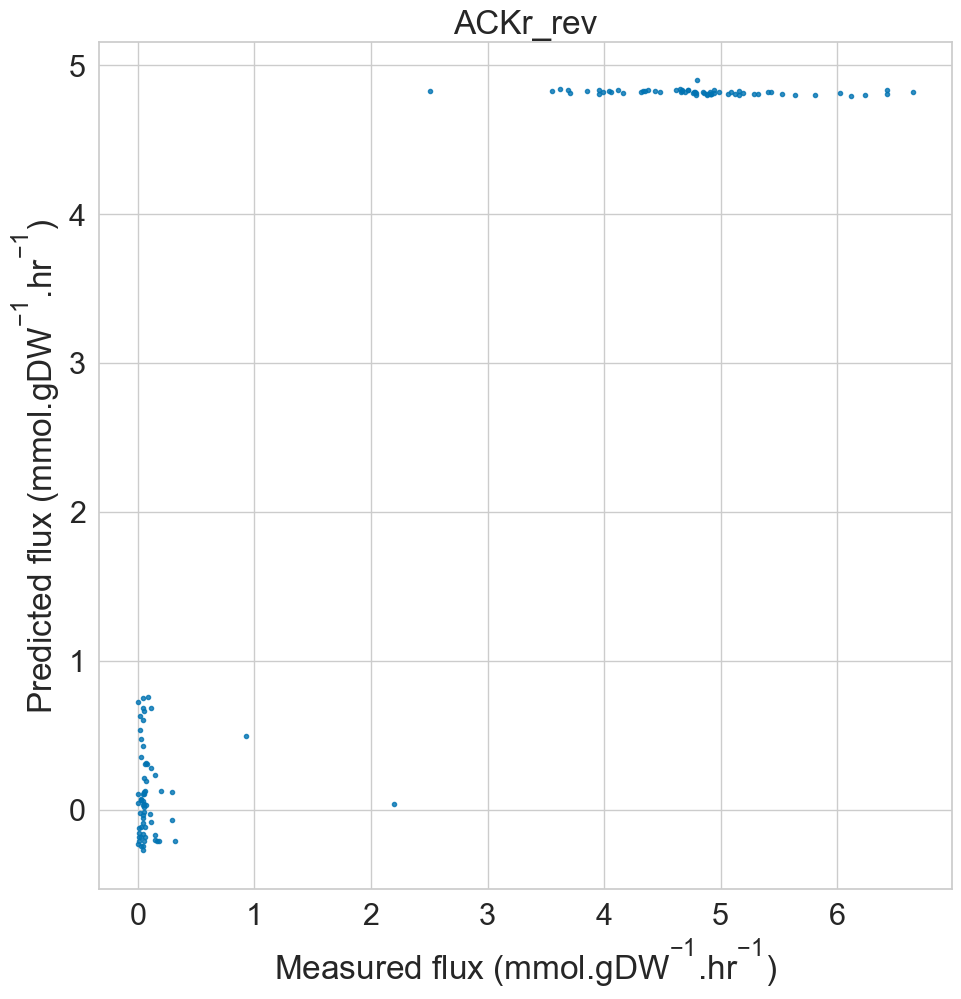

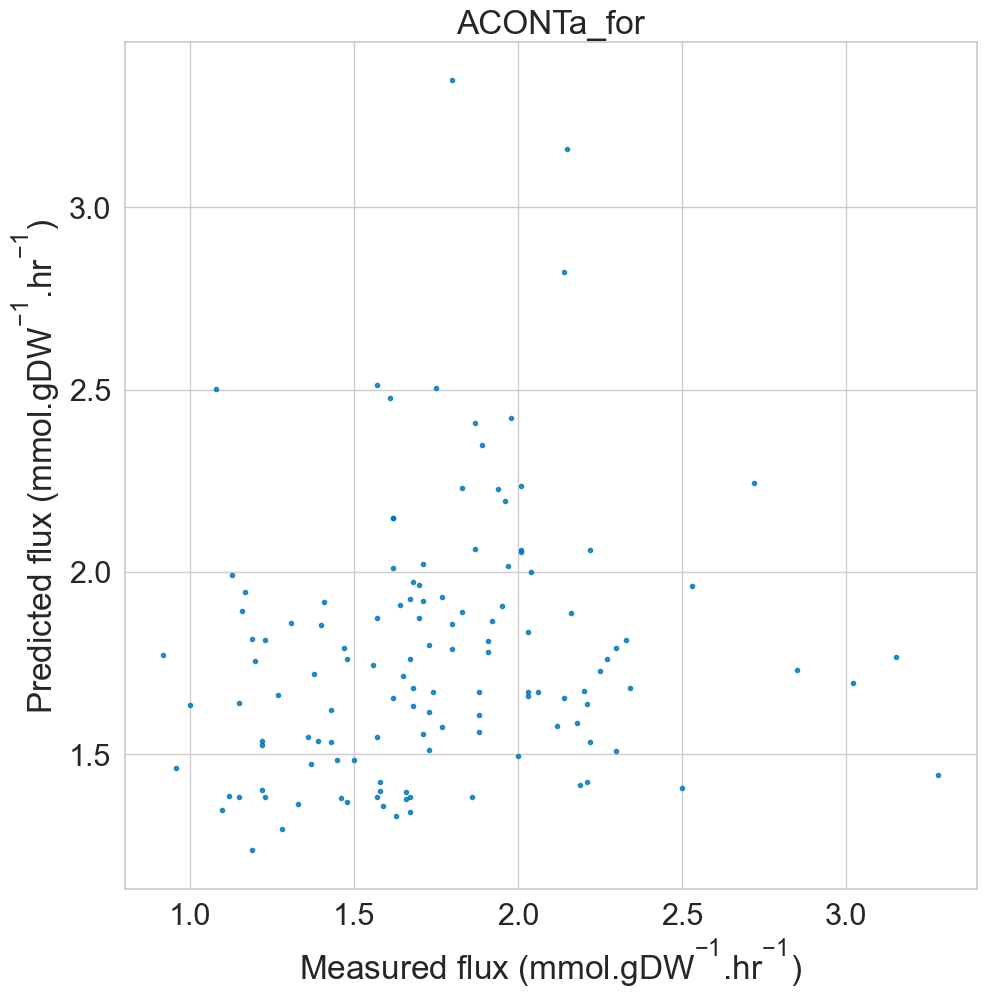

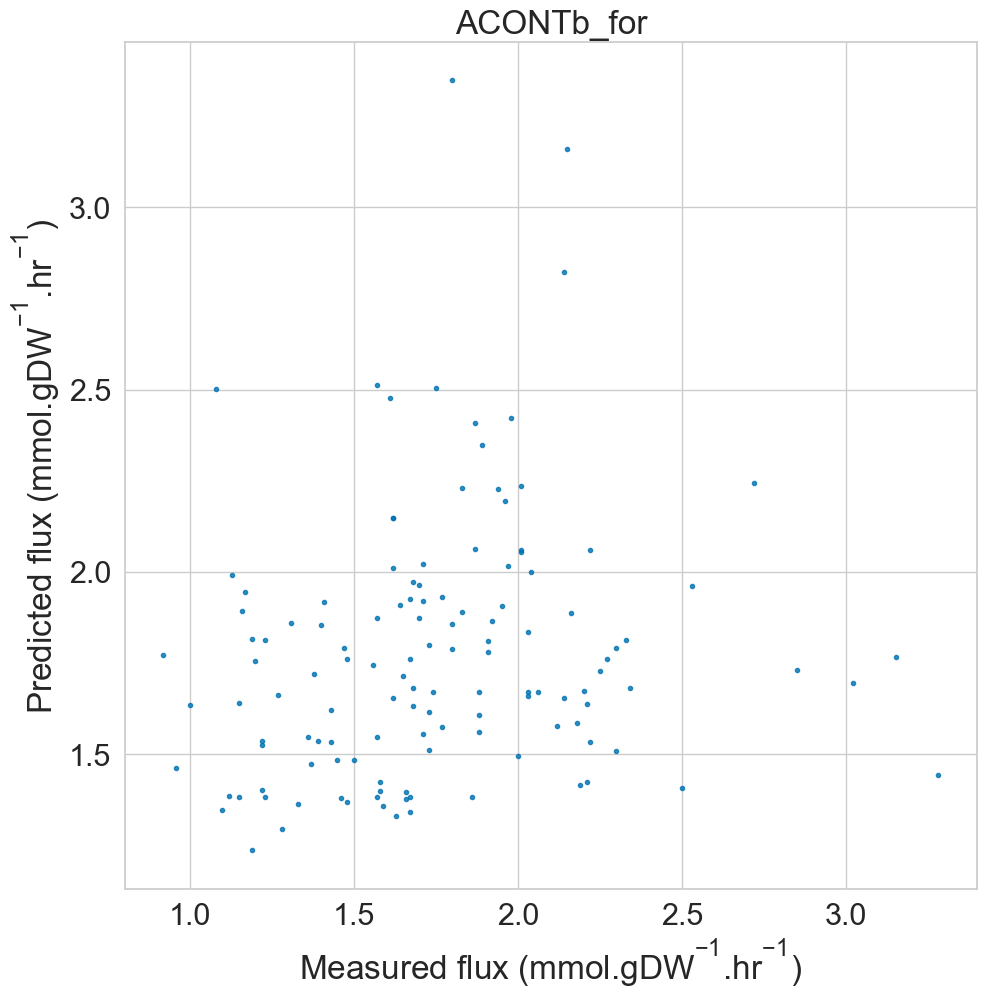

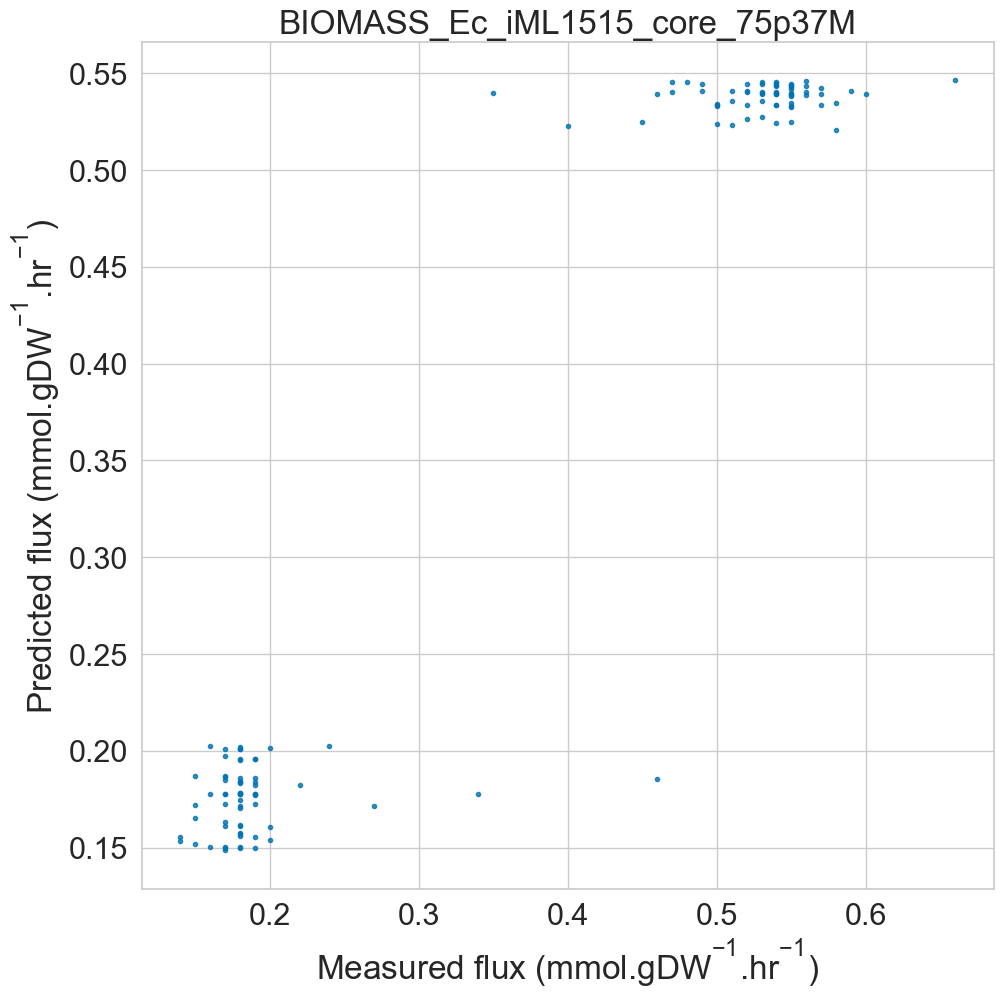

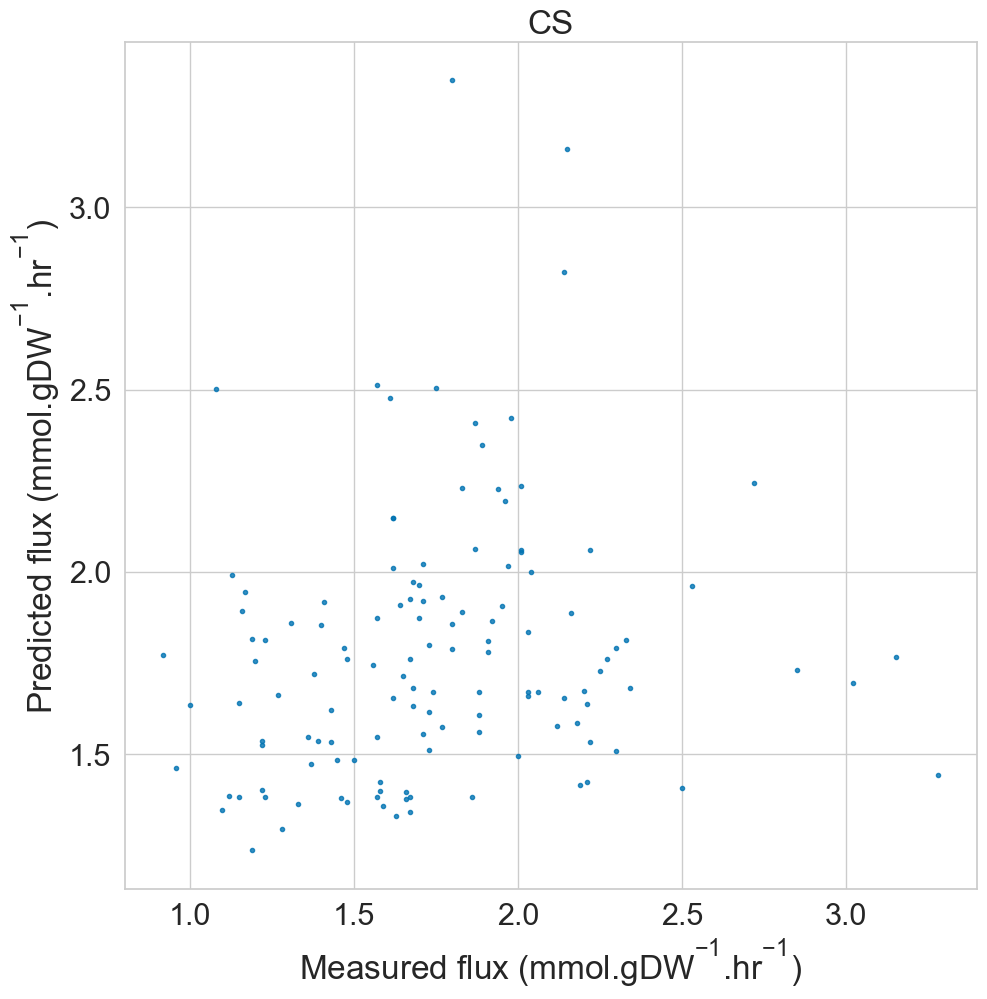

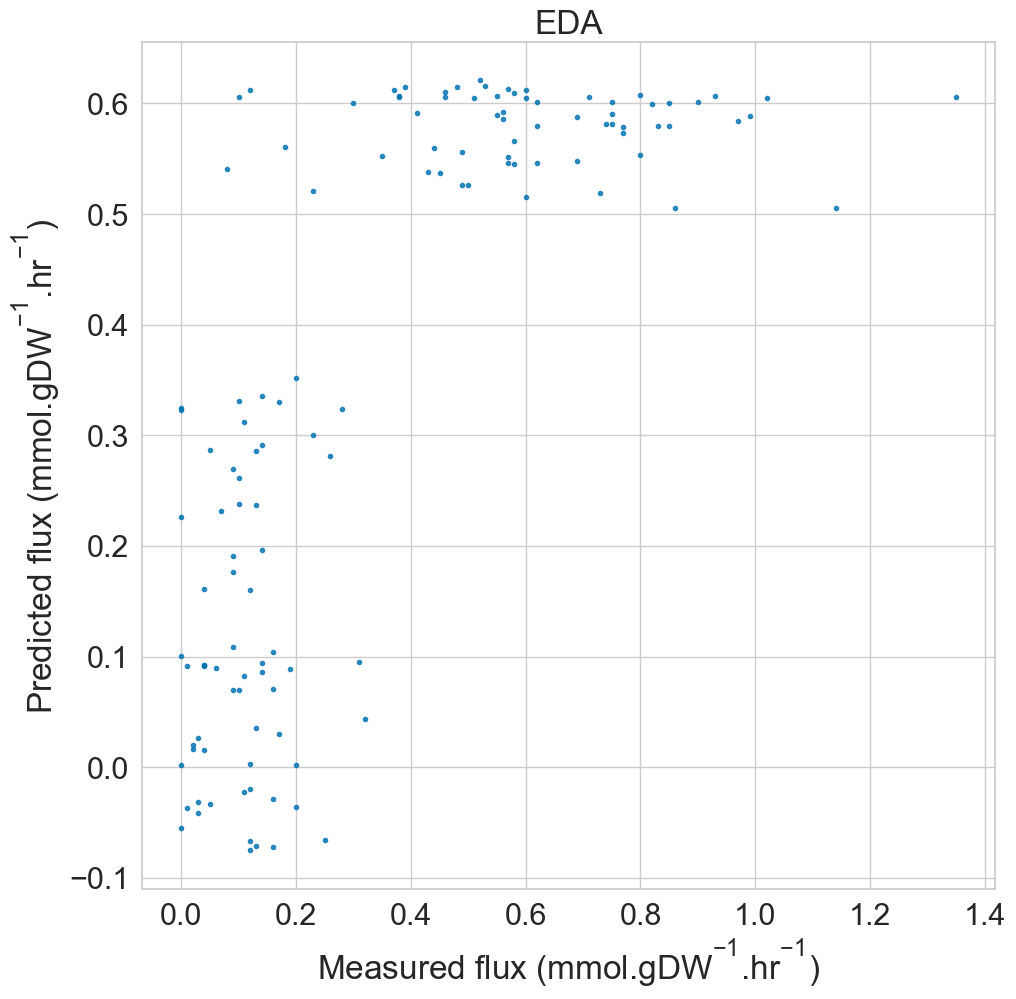

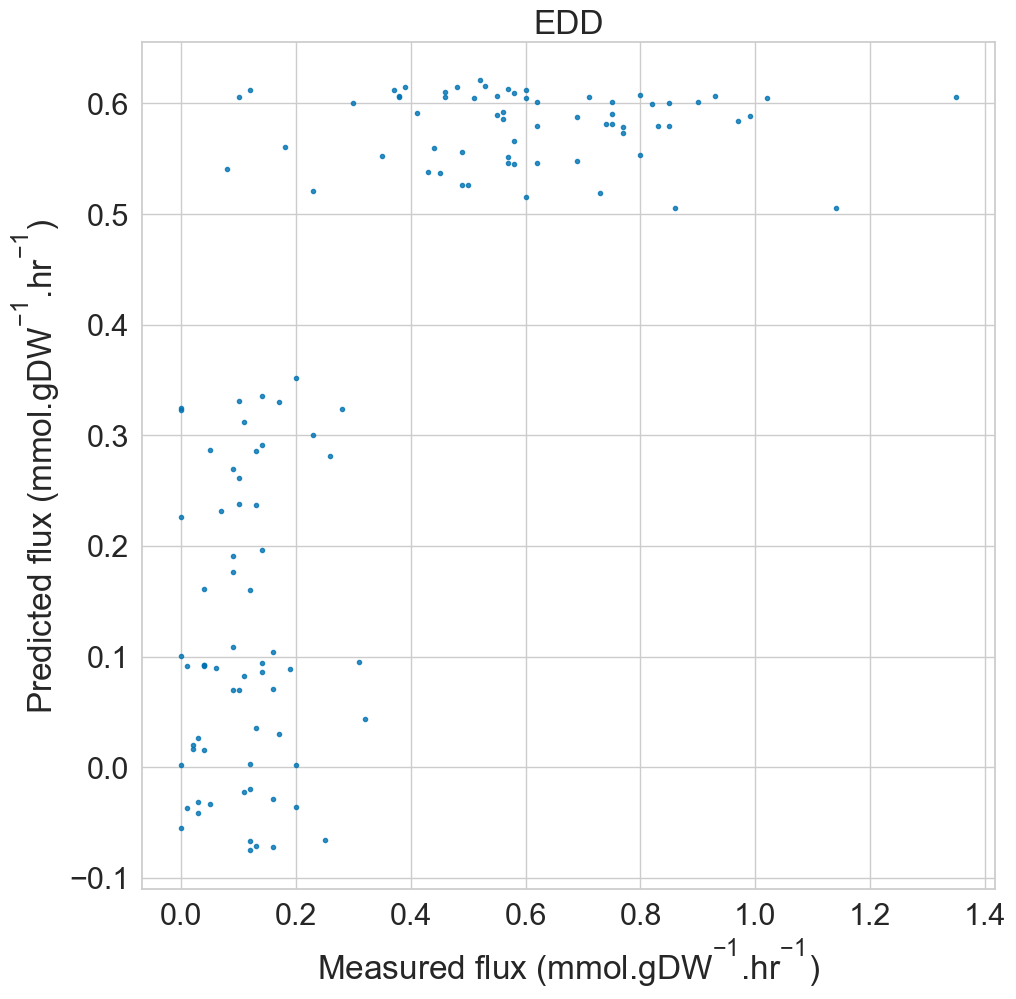

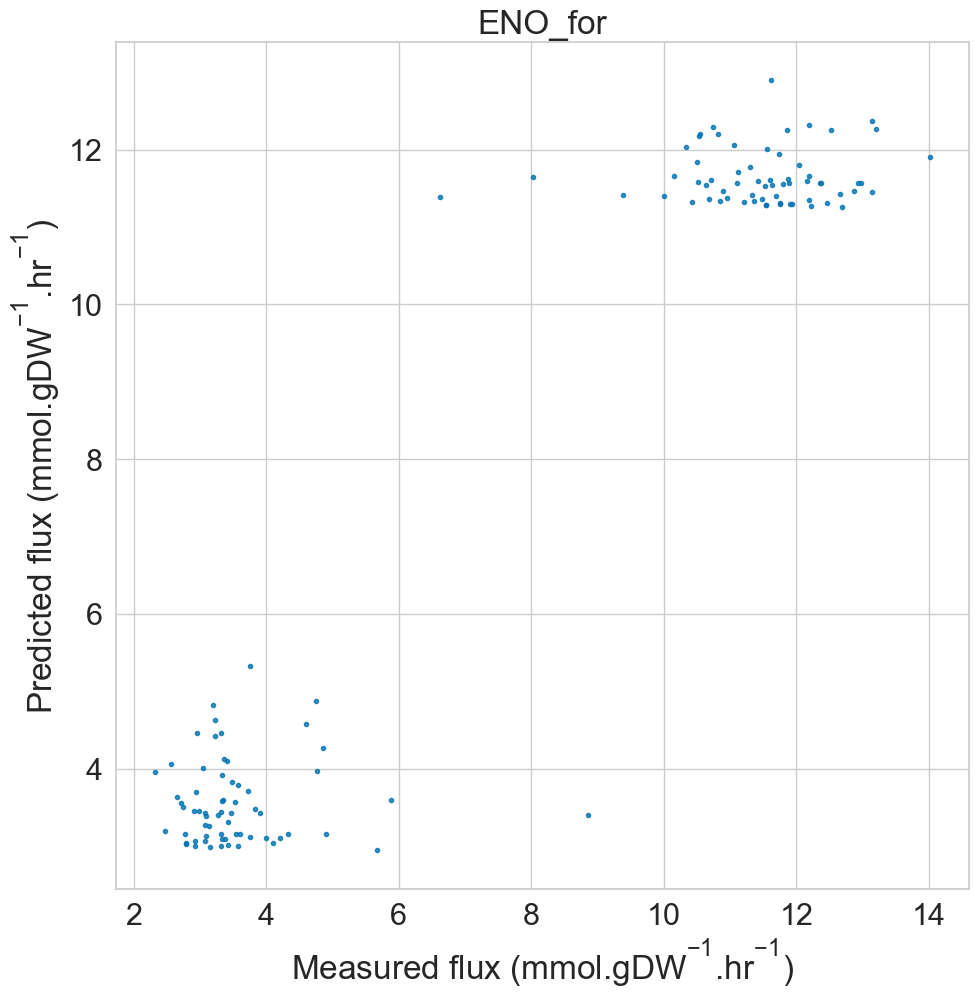

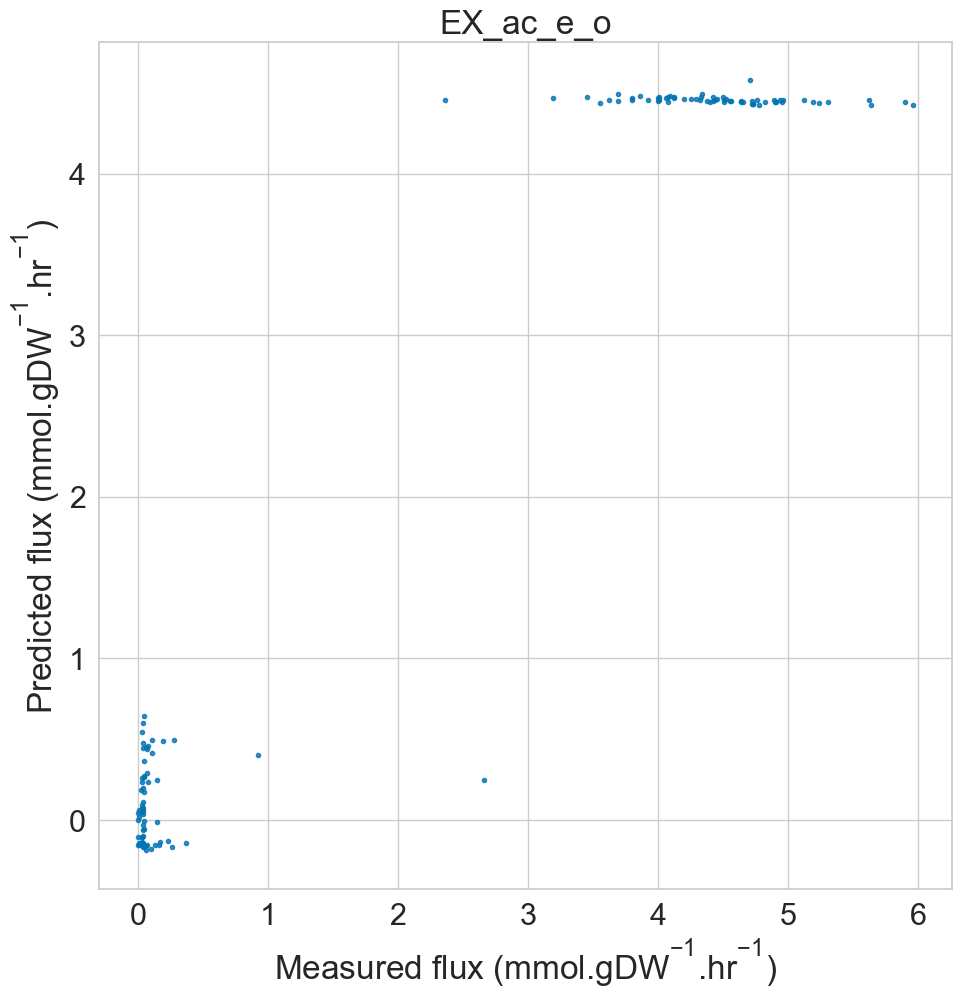

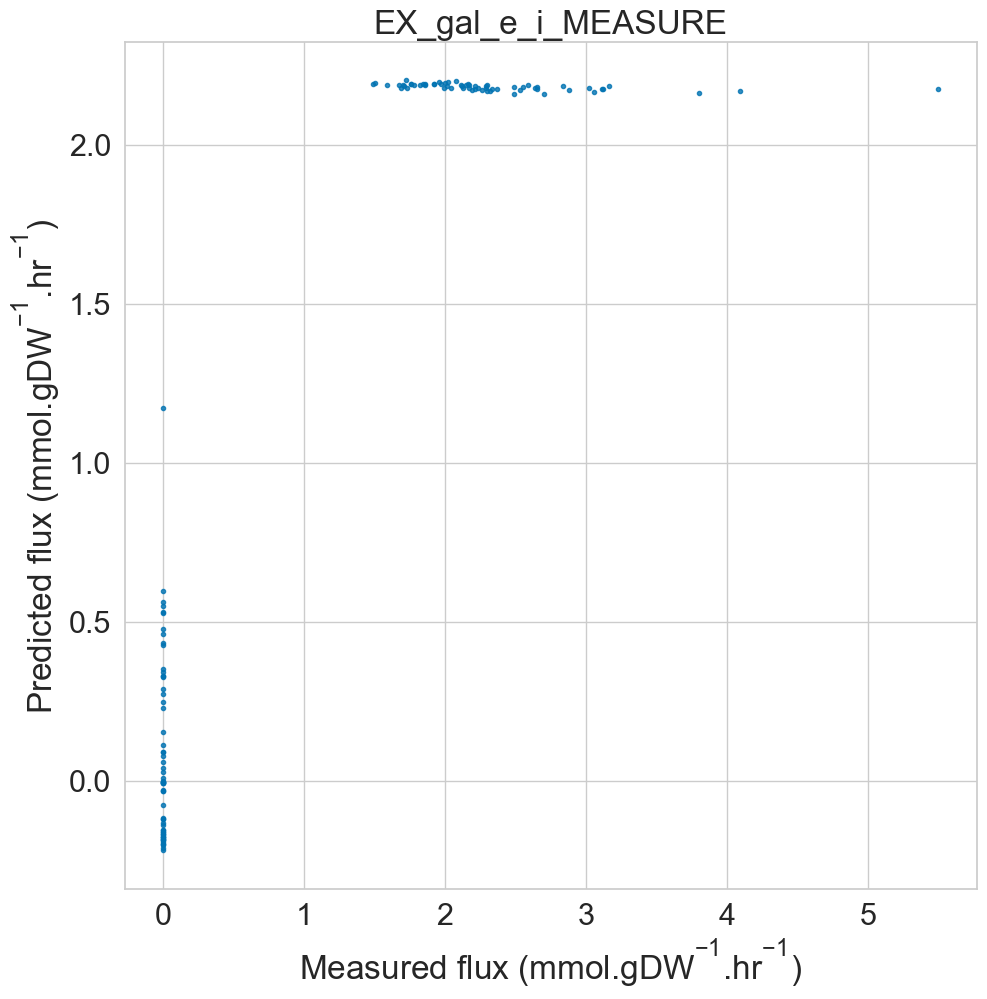

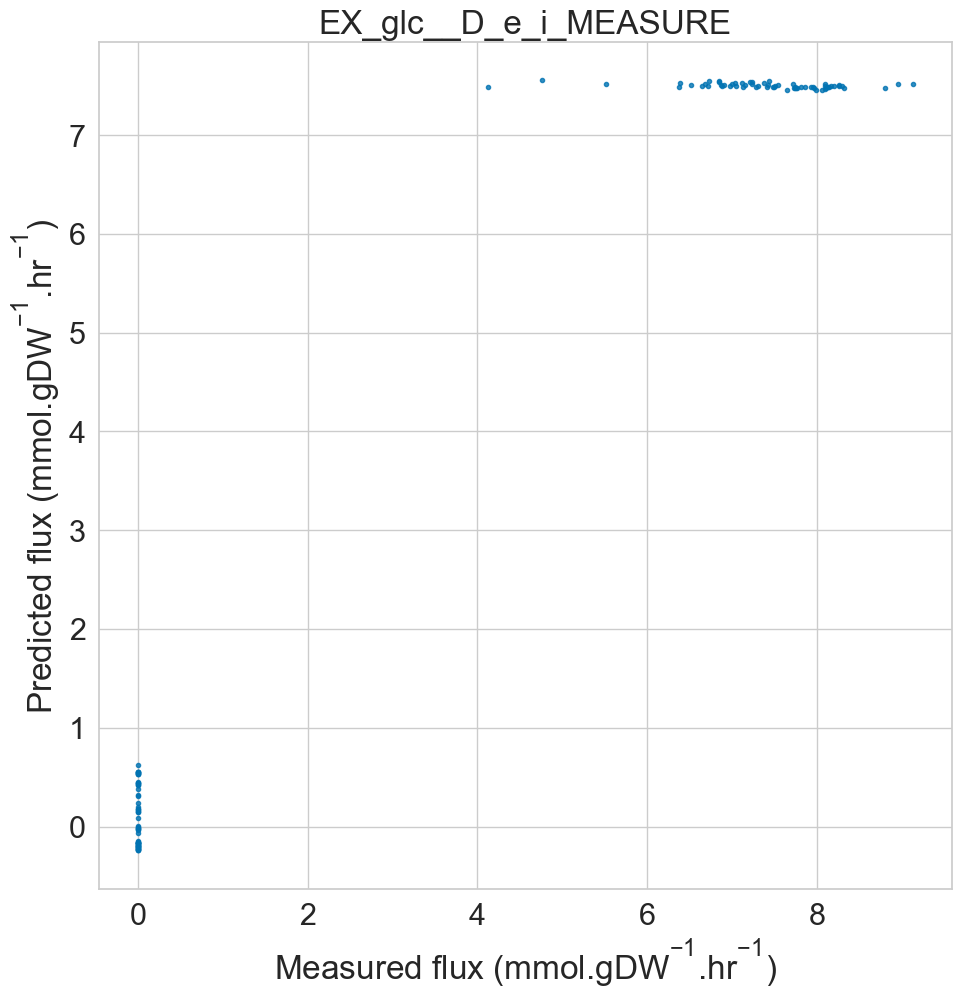

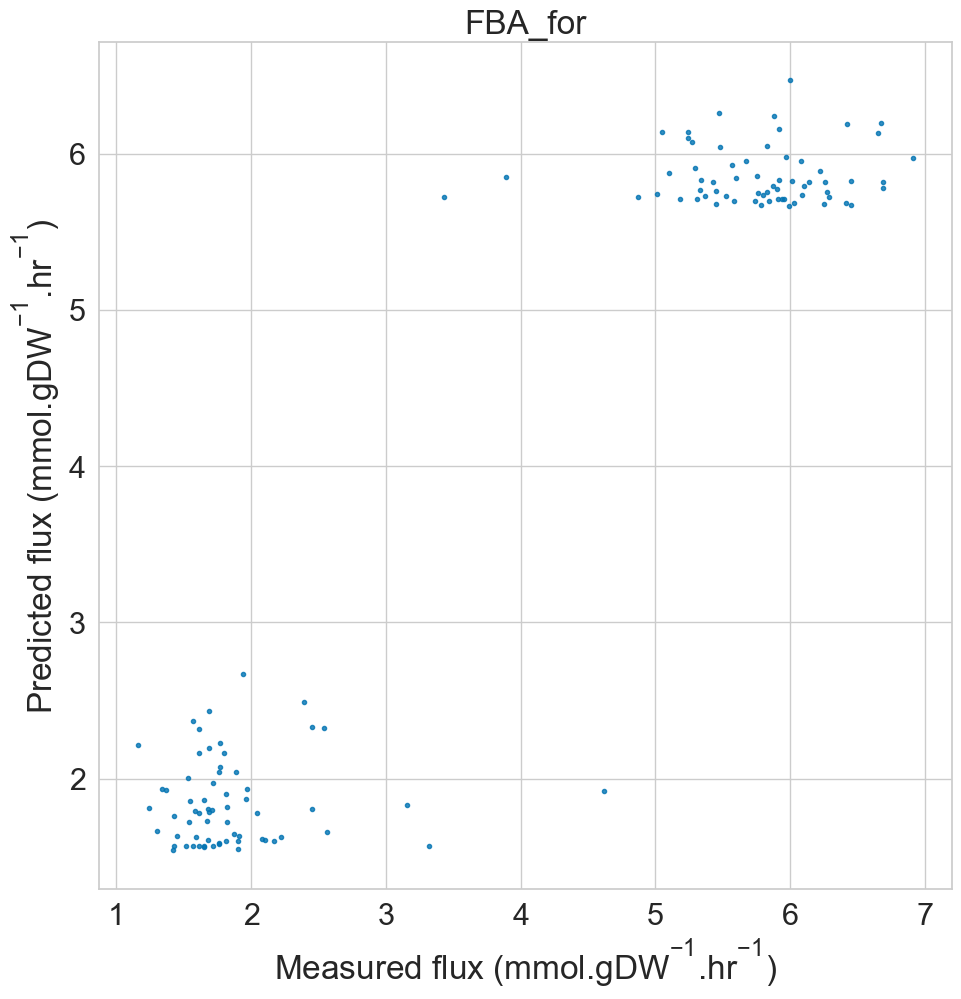

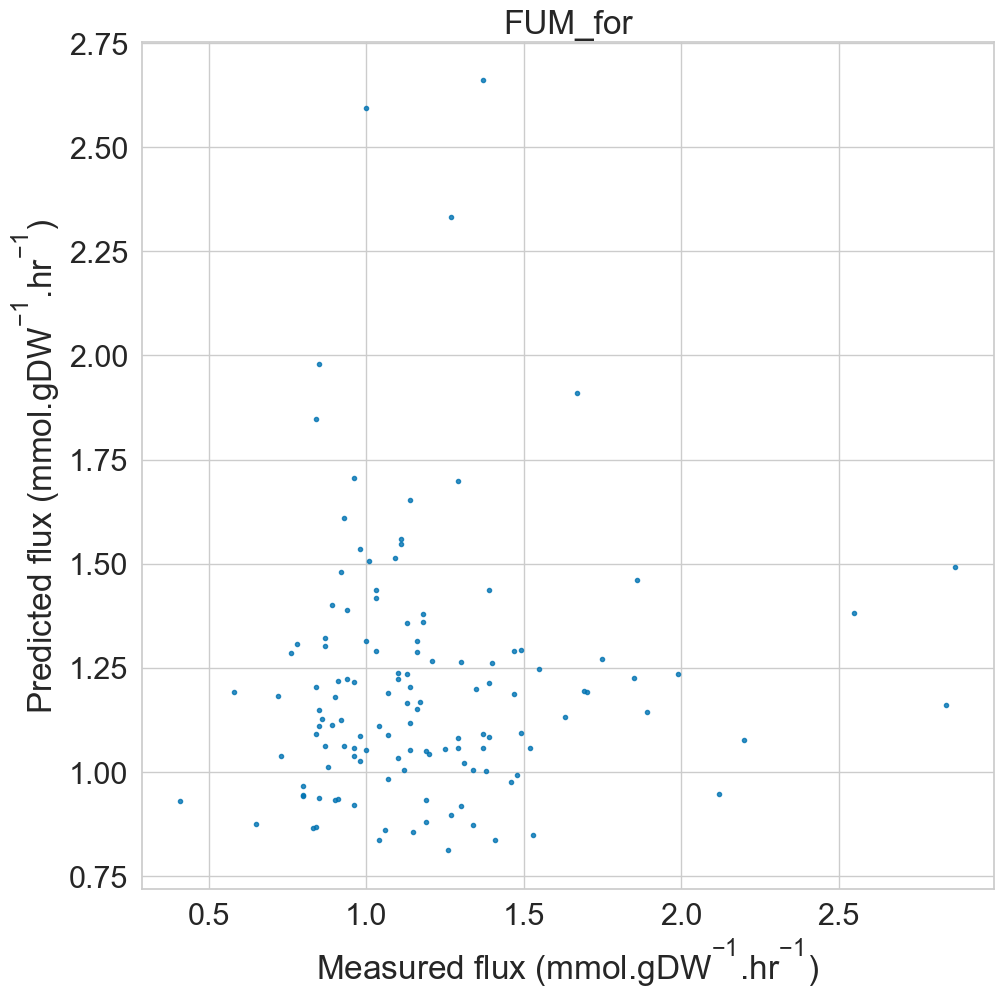

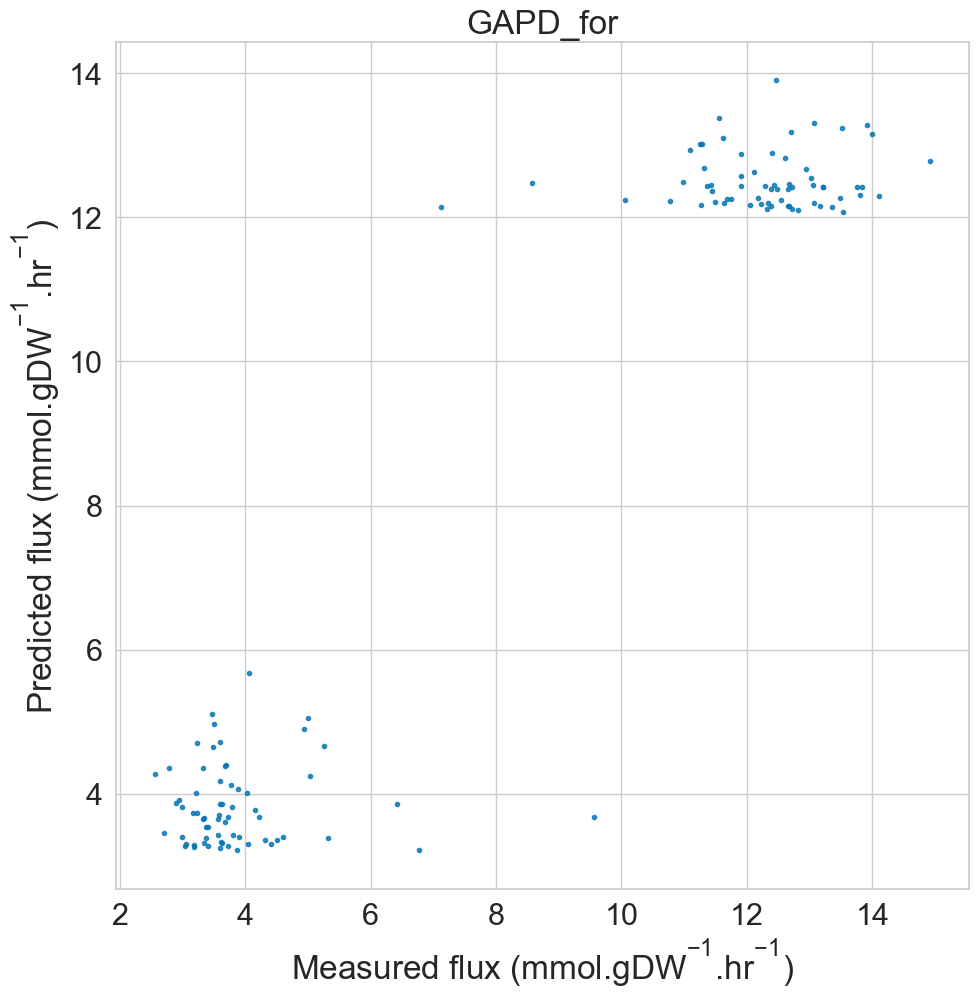

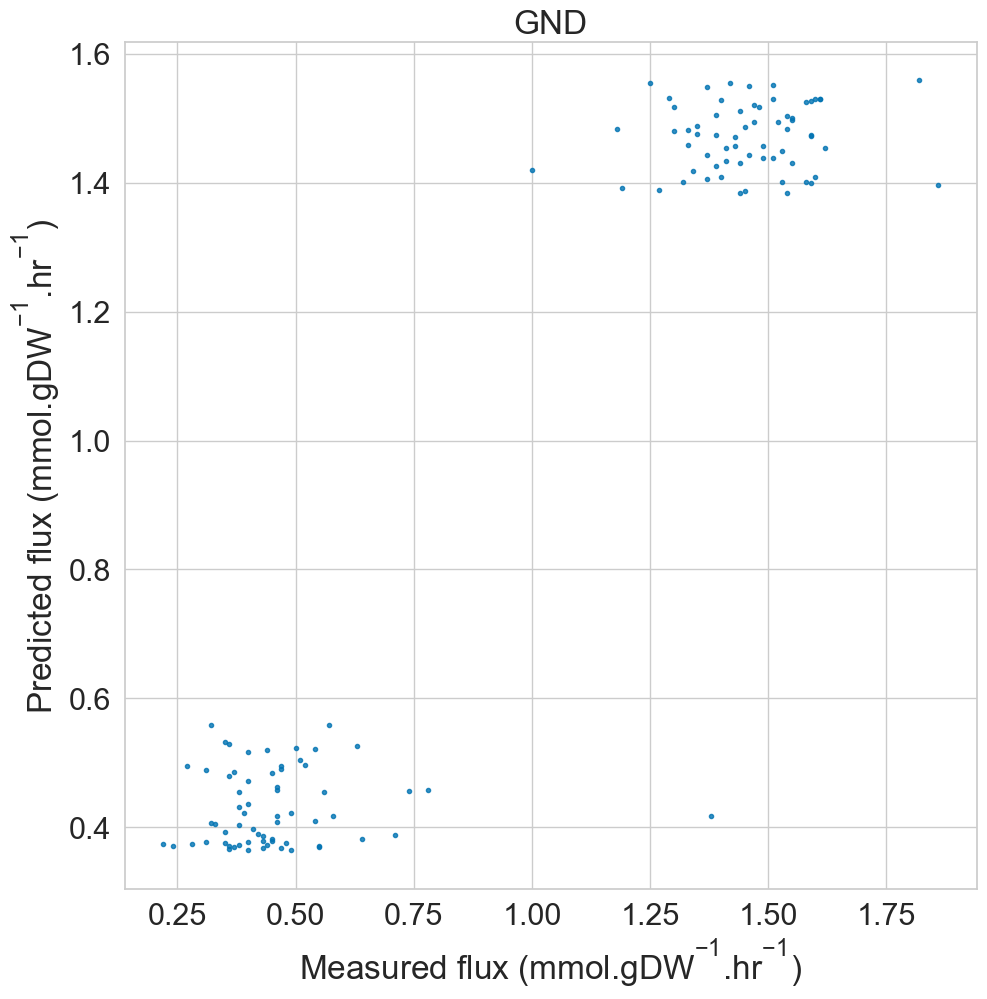

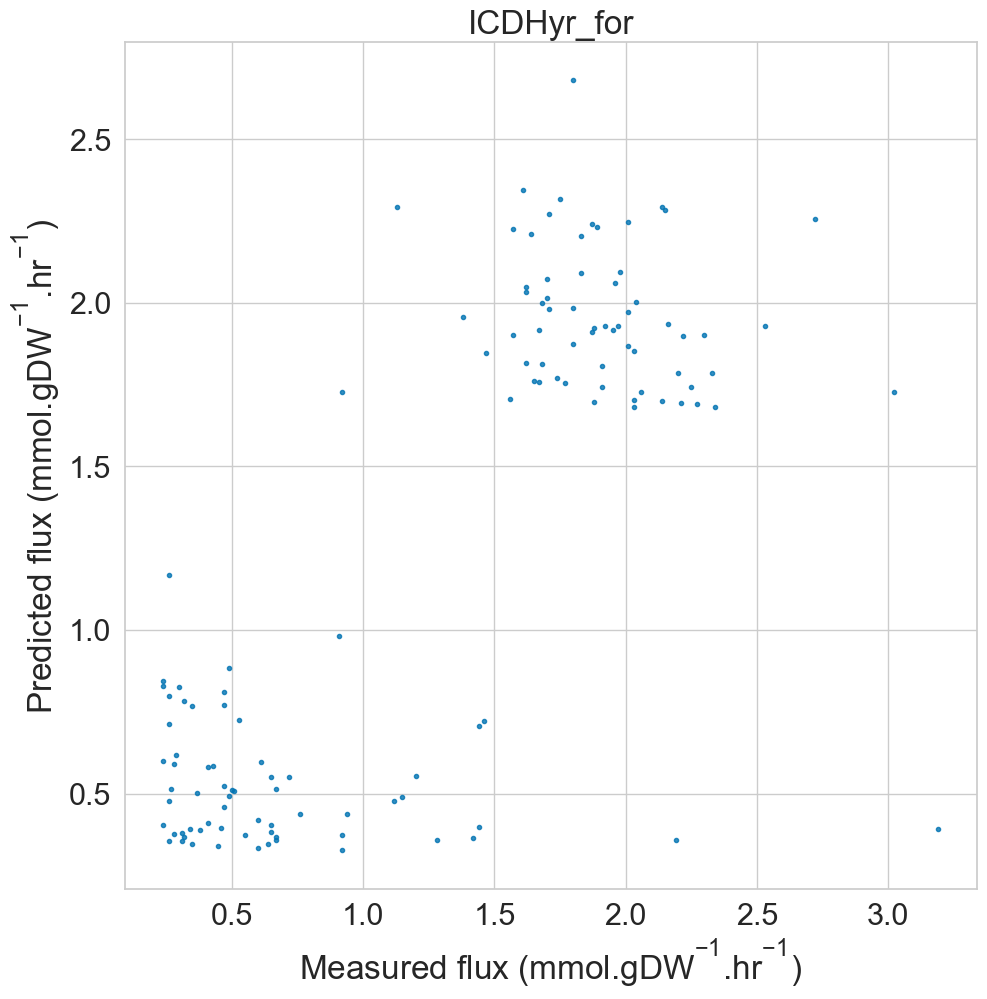

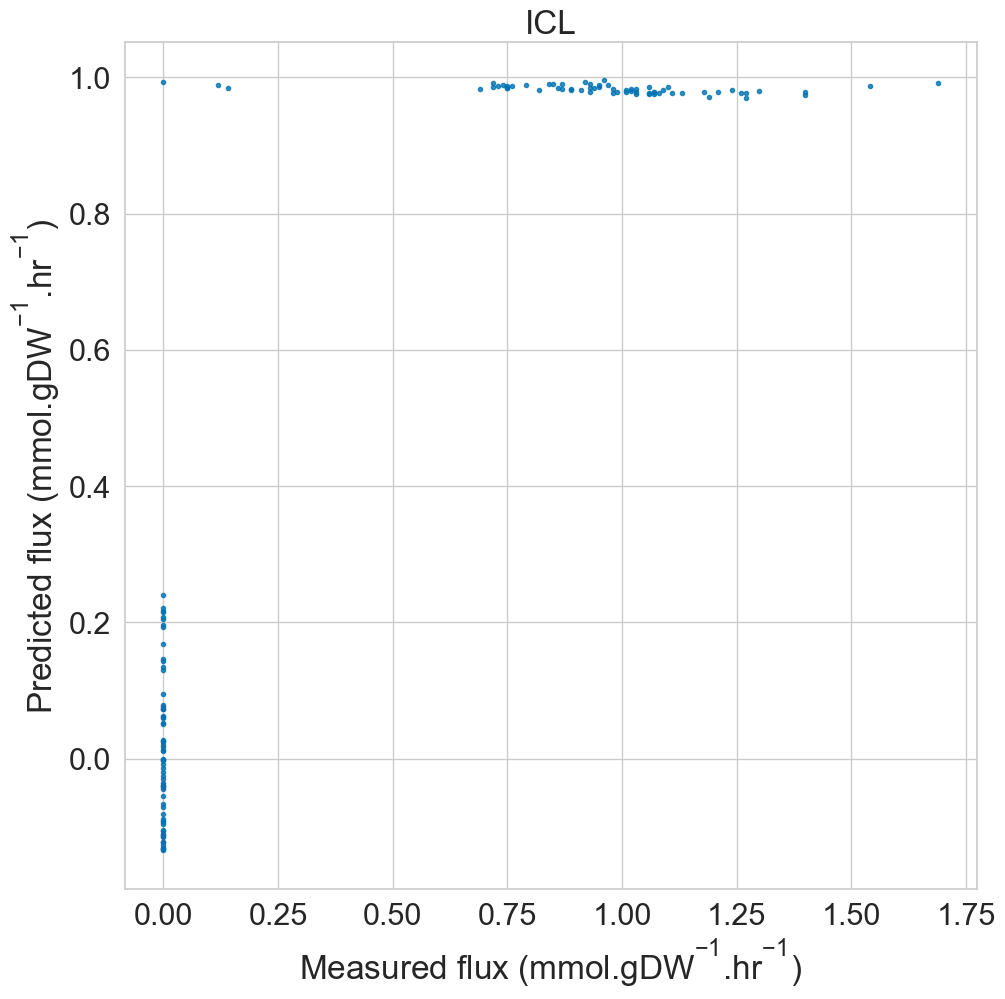

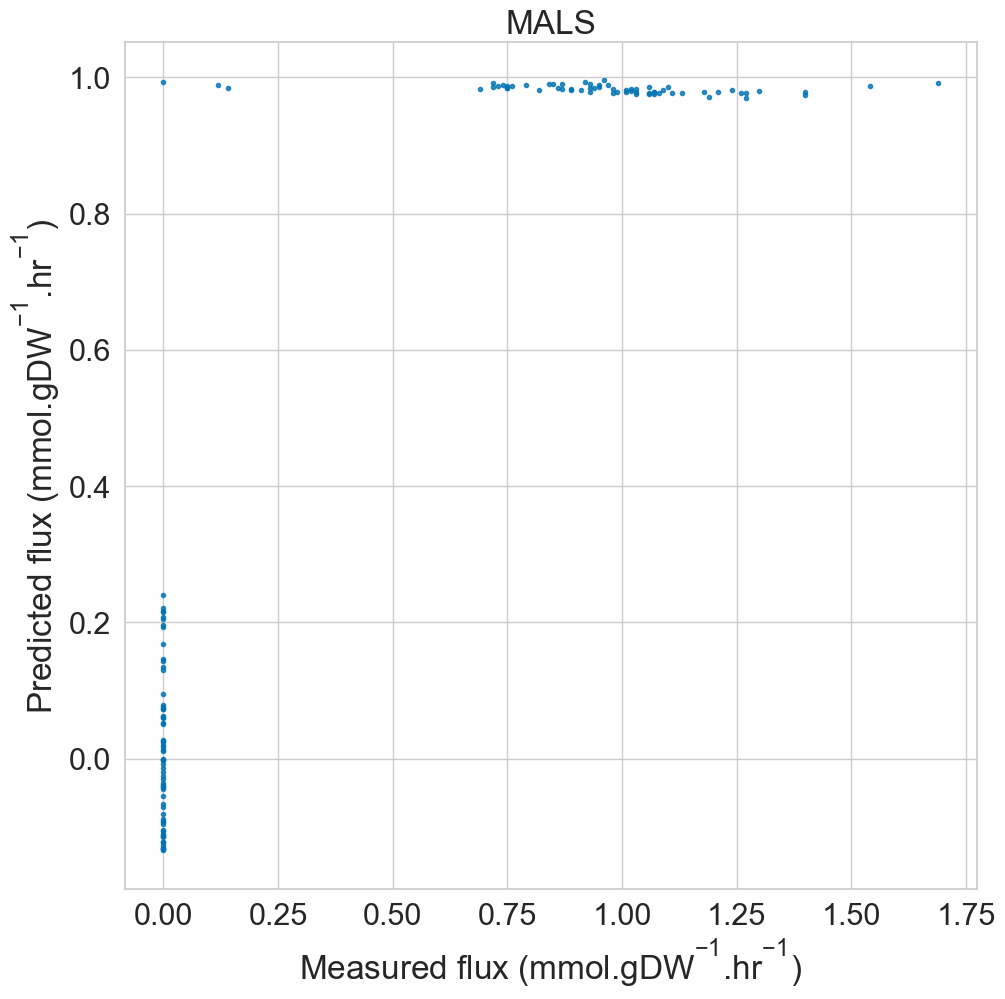

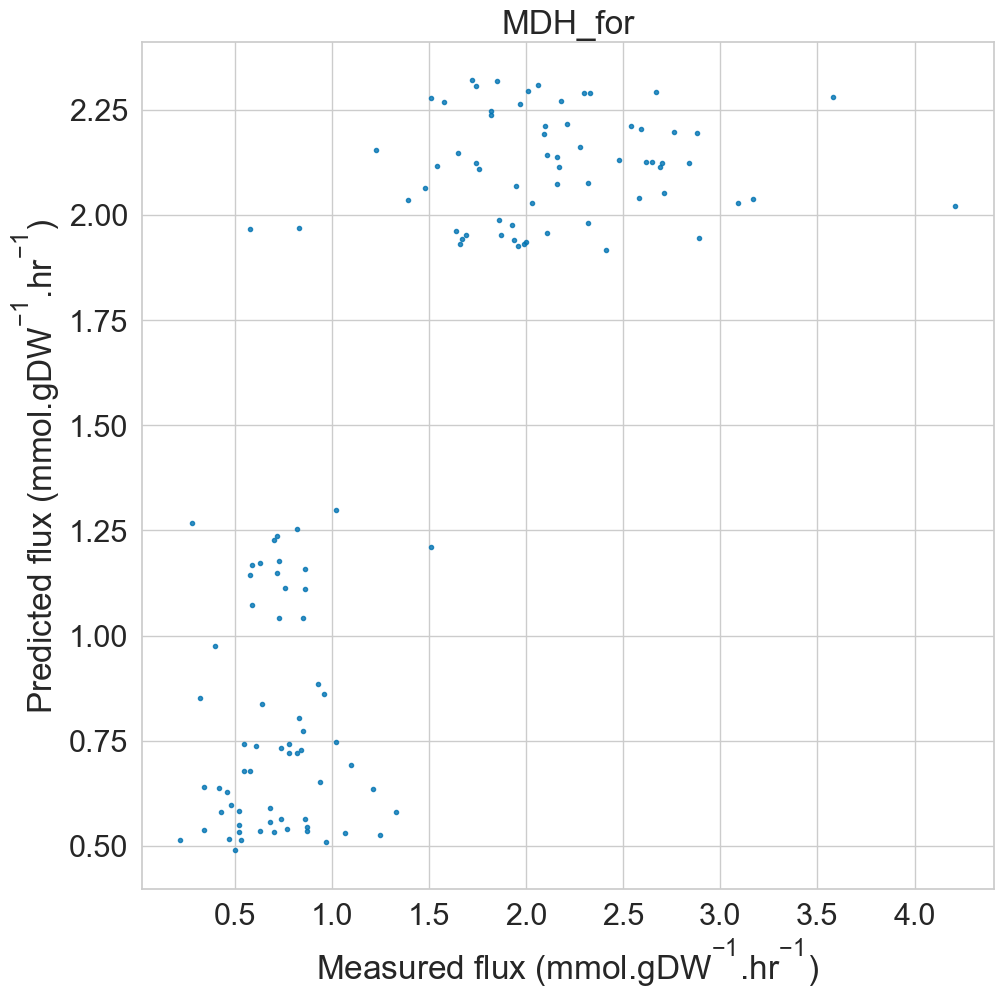

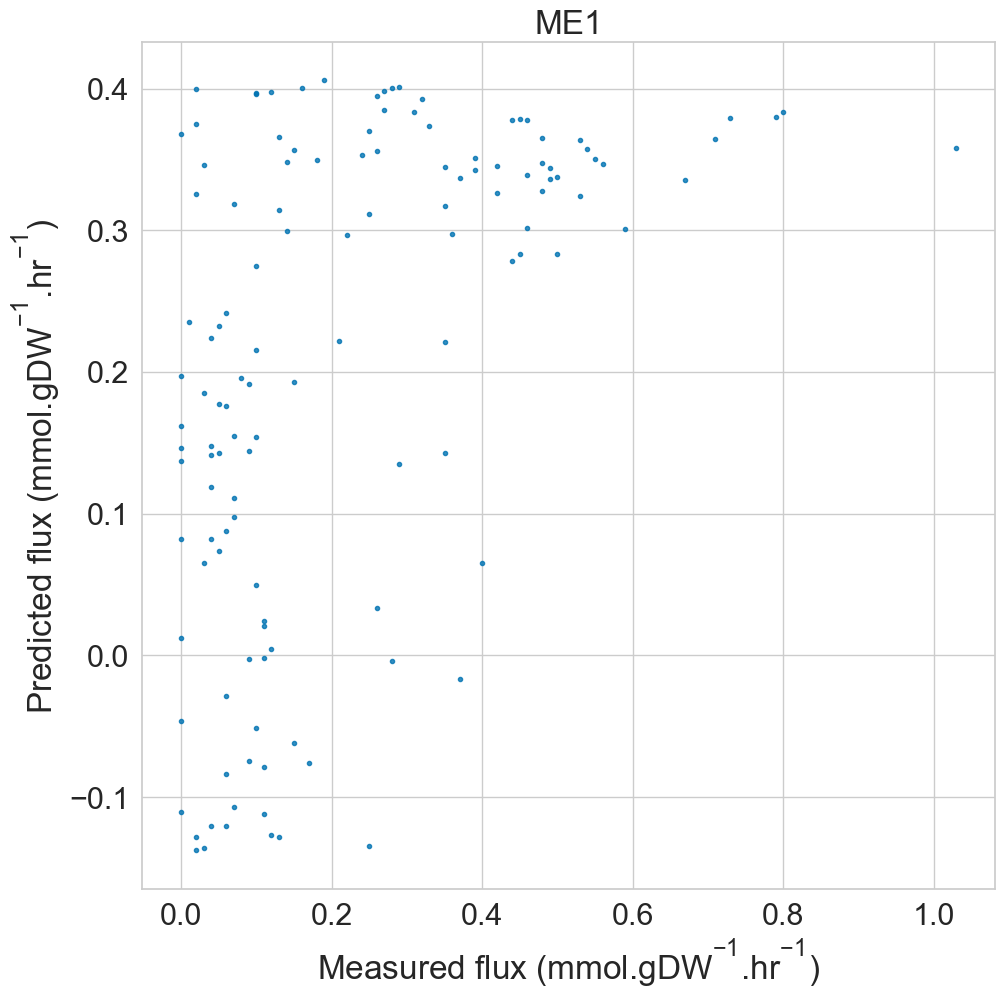

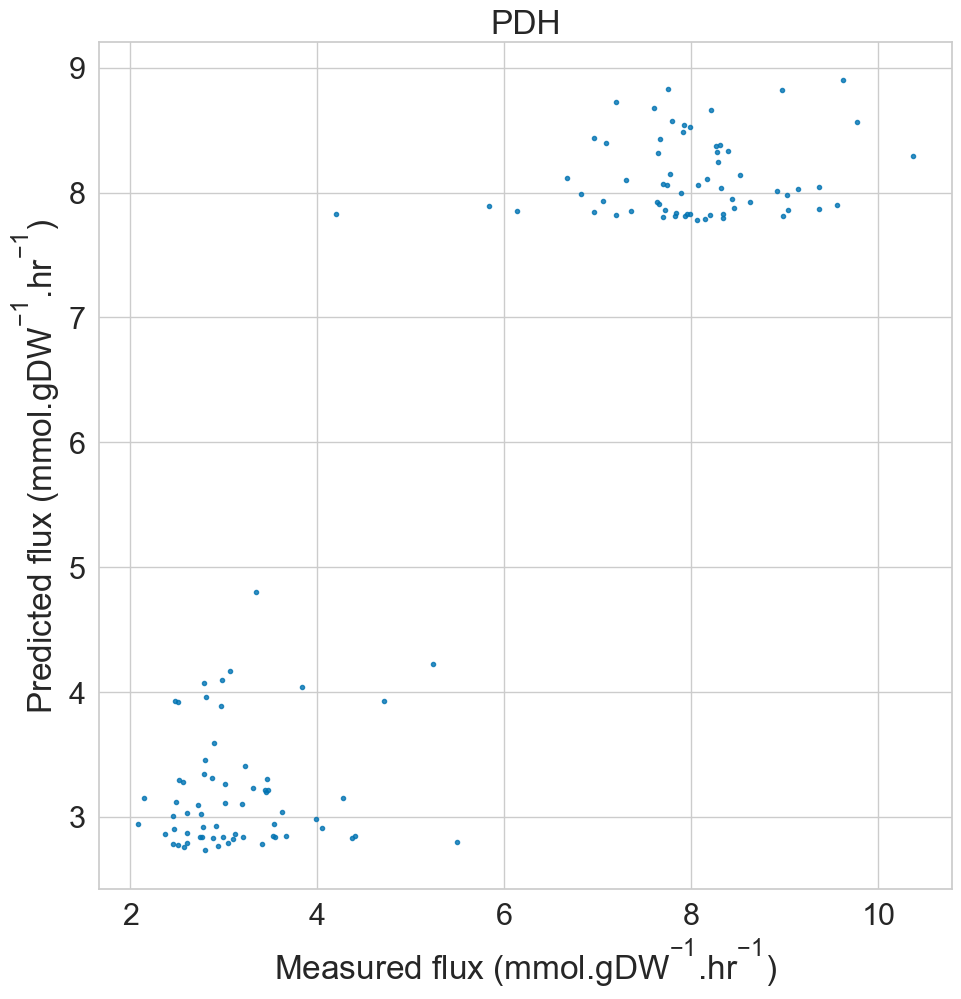

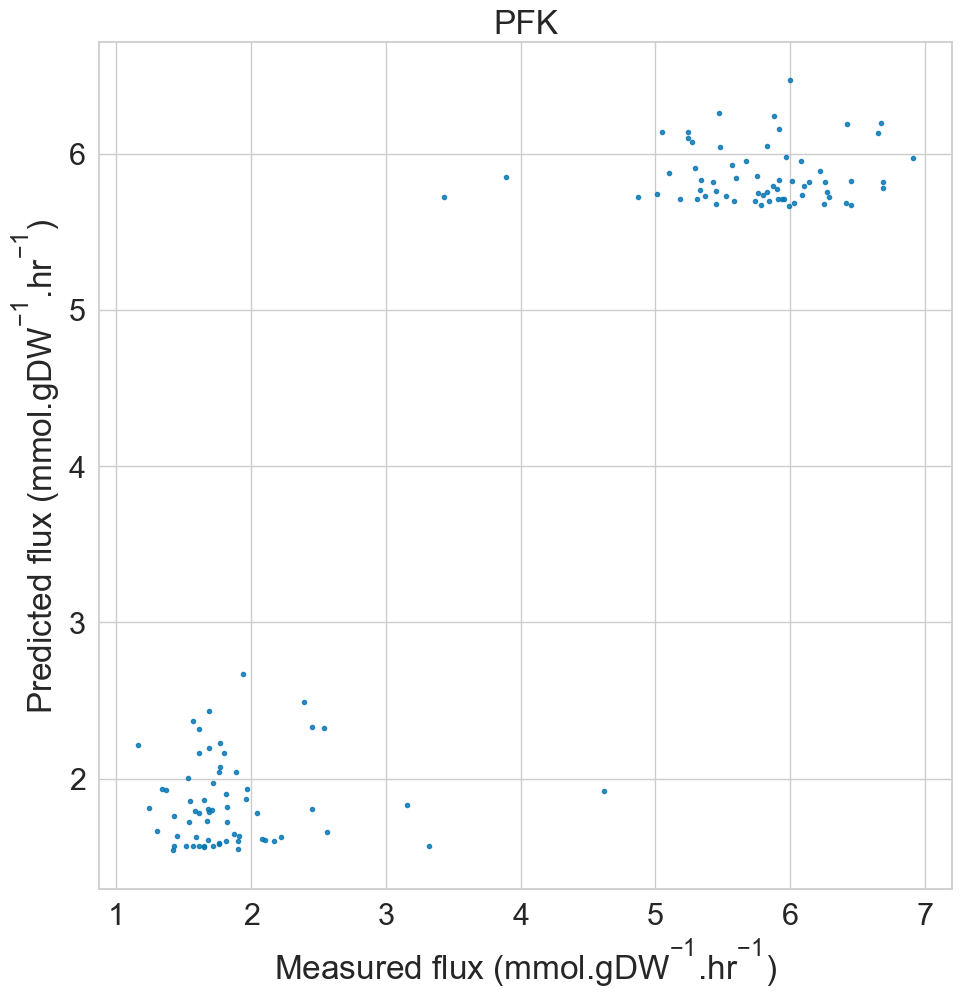

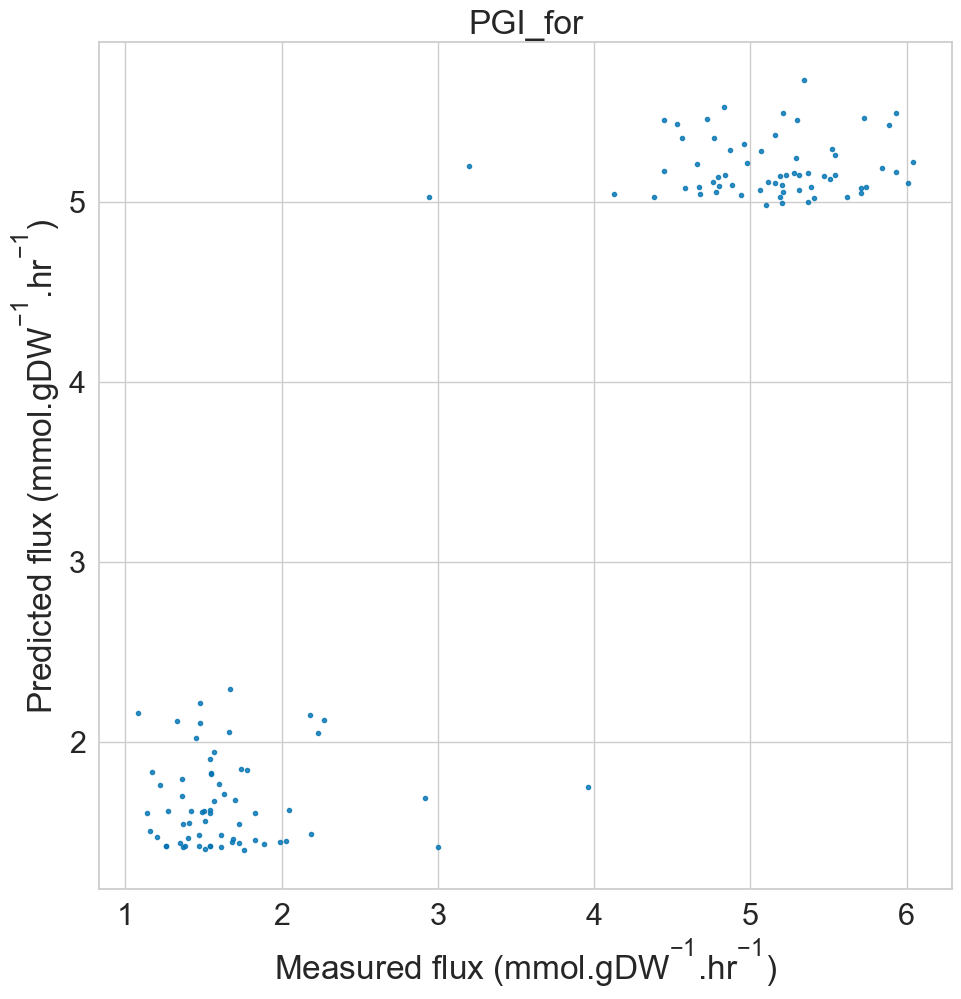

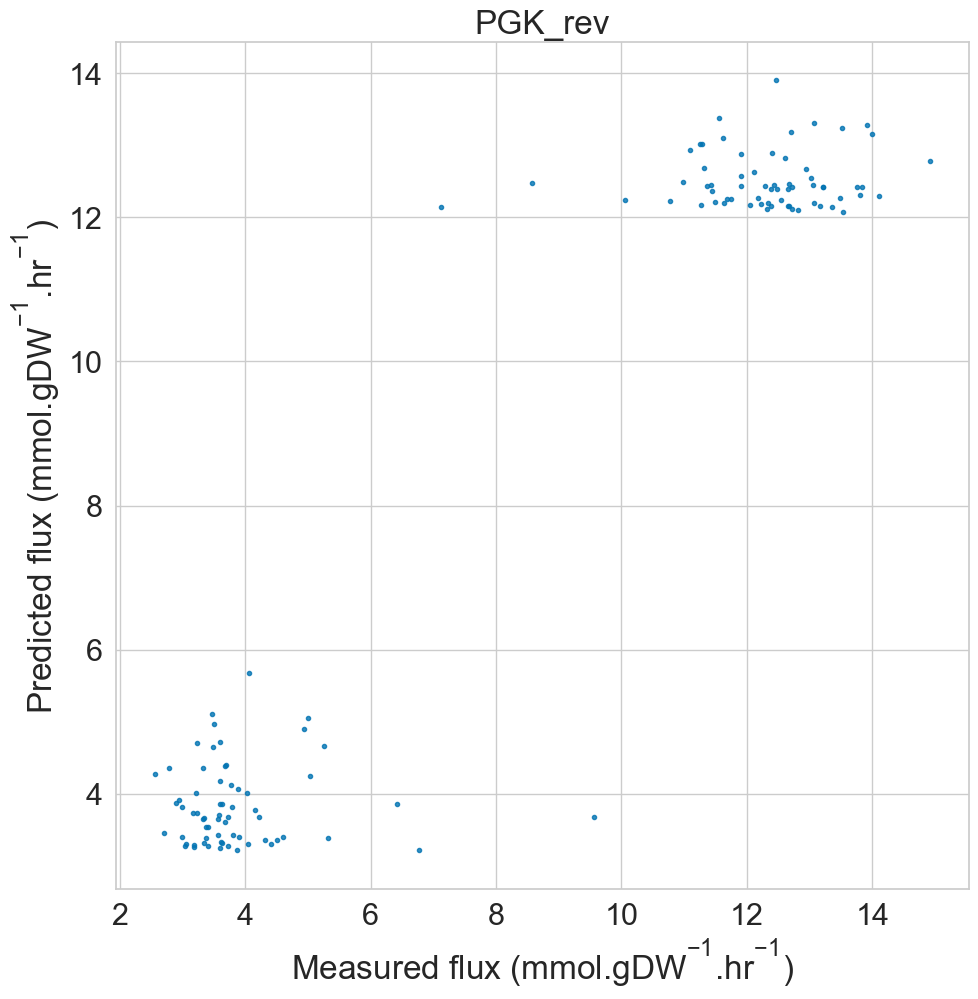

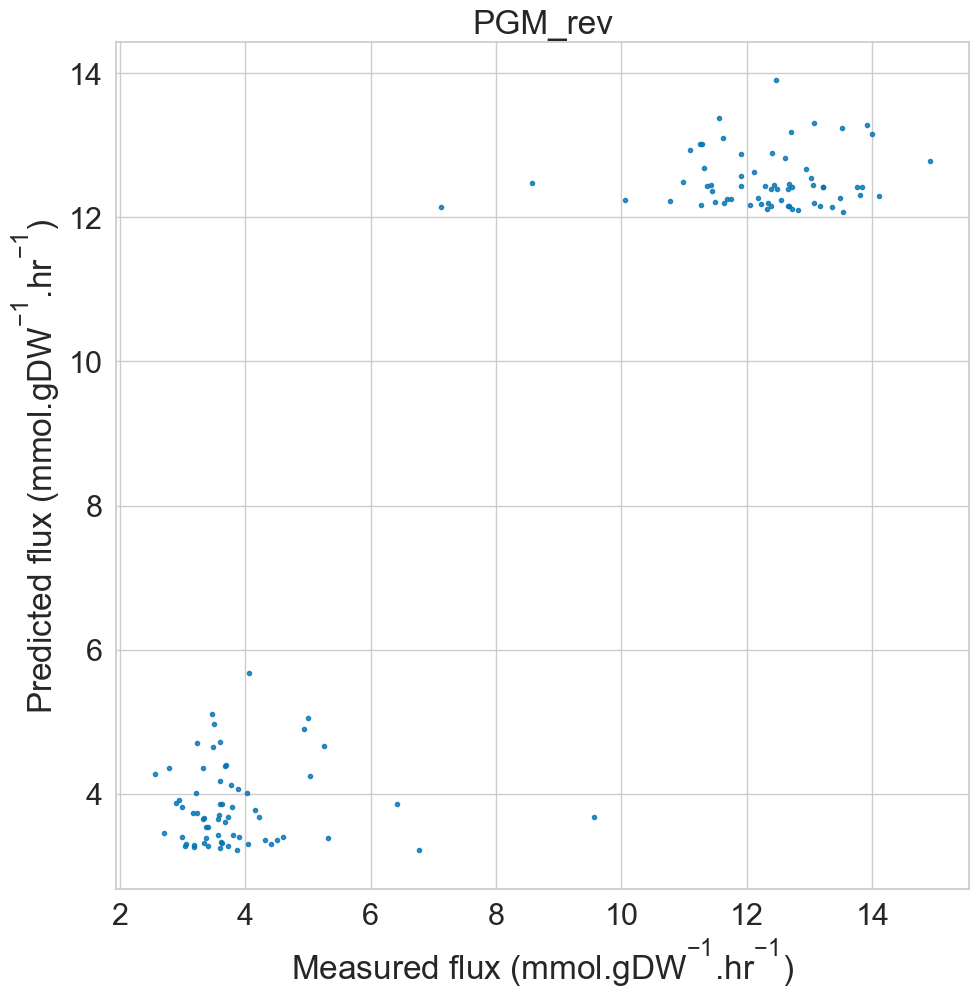

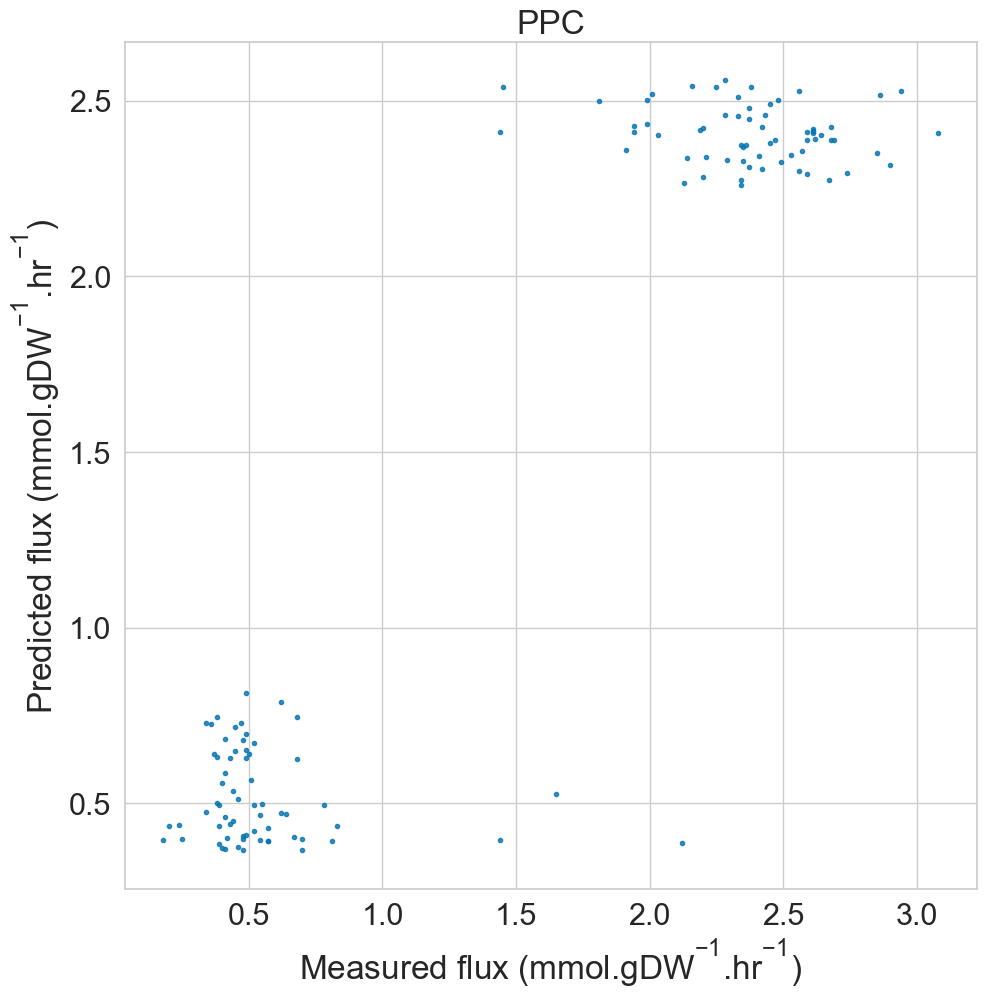

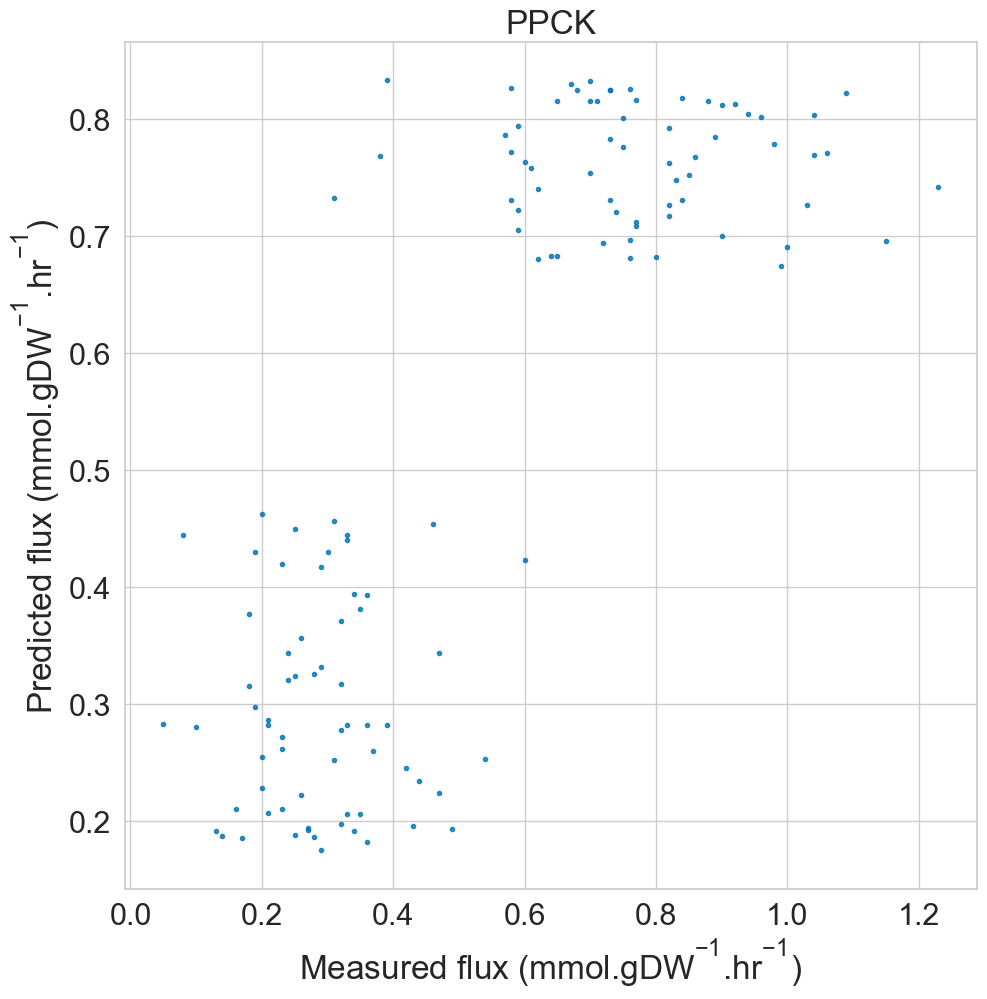

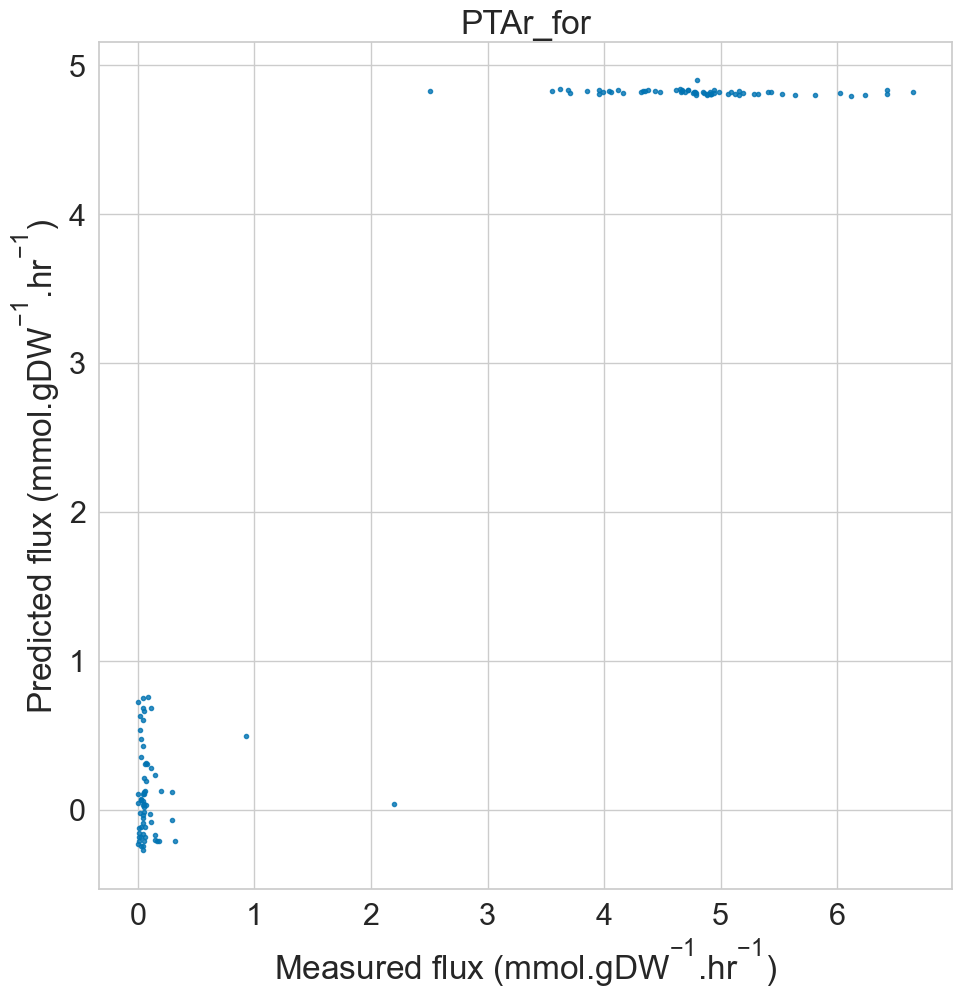

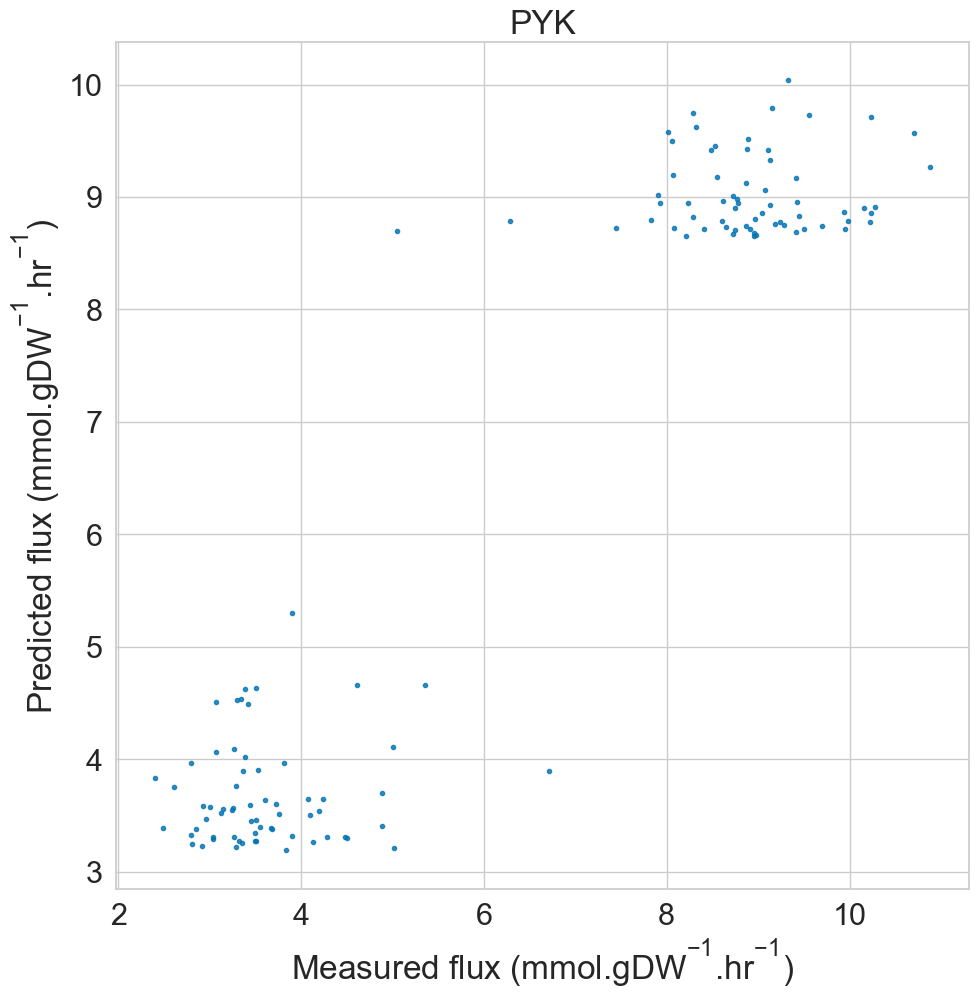

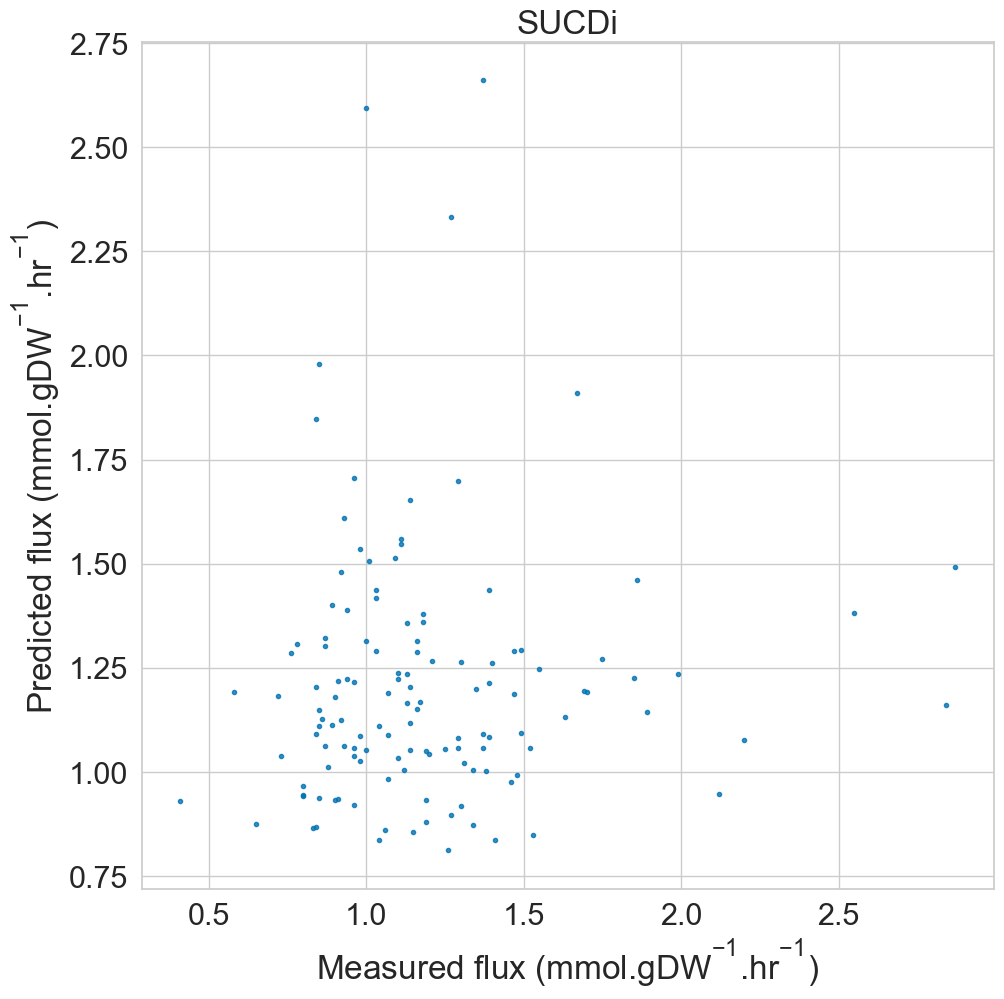

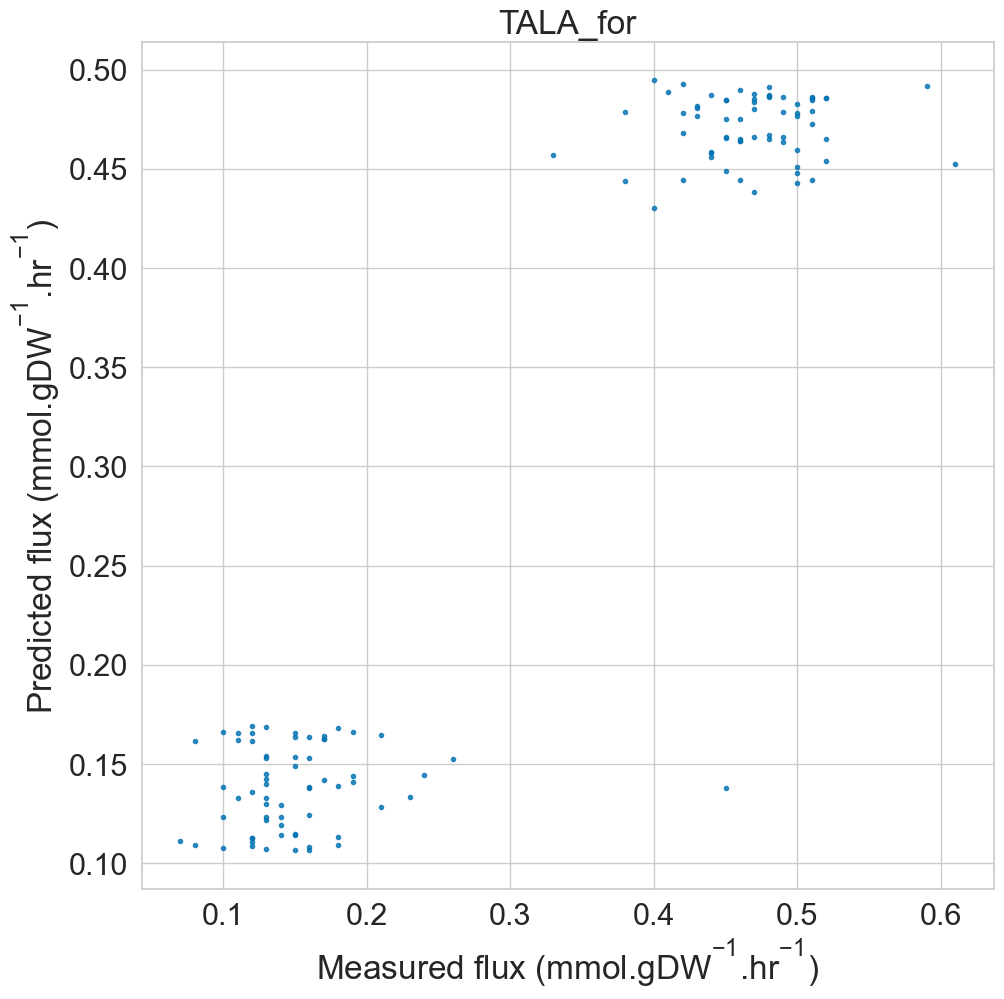

In [16]:
for flux in true_df.columns:
    TRUE = true_df[flux]
    PRED = mean_xgb_pred_df[flux]

    sns.set(font='arial', palette="colorblind", style="whitegrid", font_scale=2, rc={'figure.figsize':(11,11)})
    sns.regplot(x=TRUE, y=PRED, fit_reg=0, marker='.')
    # sns.lineplot([min(TRUE.ravel()), max(TRUE.ravel())], [min(TRUE.ravel()), max(TRUE.ravel())], color='y')
    plt.xlabel("Measured flux (mmol." + r'$\mathregular{gDW^{-1}}$' + '.' + r'$\mathregular{hr^{-1}}$' +")")
    plt.ylabel("Predicted flux (mmol." + r'$\mathregular{gDW^{-1}}$' + '.' + r'$\mathregular{hr^{-1}}$' +")")
    # plt.xlim(min(TRUE)-0.01, max(TRUE)+0.05)
    # plt.ylim(min(PRED)-0.02, max(PRED)+0.05)
    plt.title(str(flux))
    plt.show()
    # plt.savefig("RegPerf_cobra.png", dpi=500)

<AxesSubplot:>

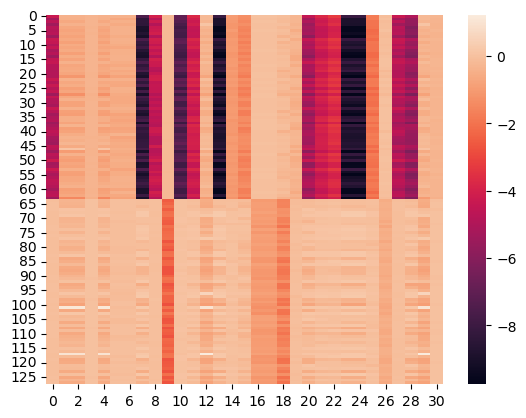

In [6]:
sns.heatmap(mean_xgb_pred)

<AxesSubplot:>

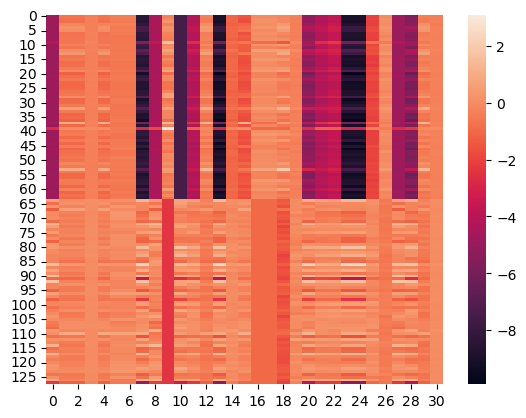

In [7]:
sns.heatmap(Y)

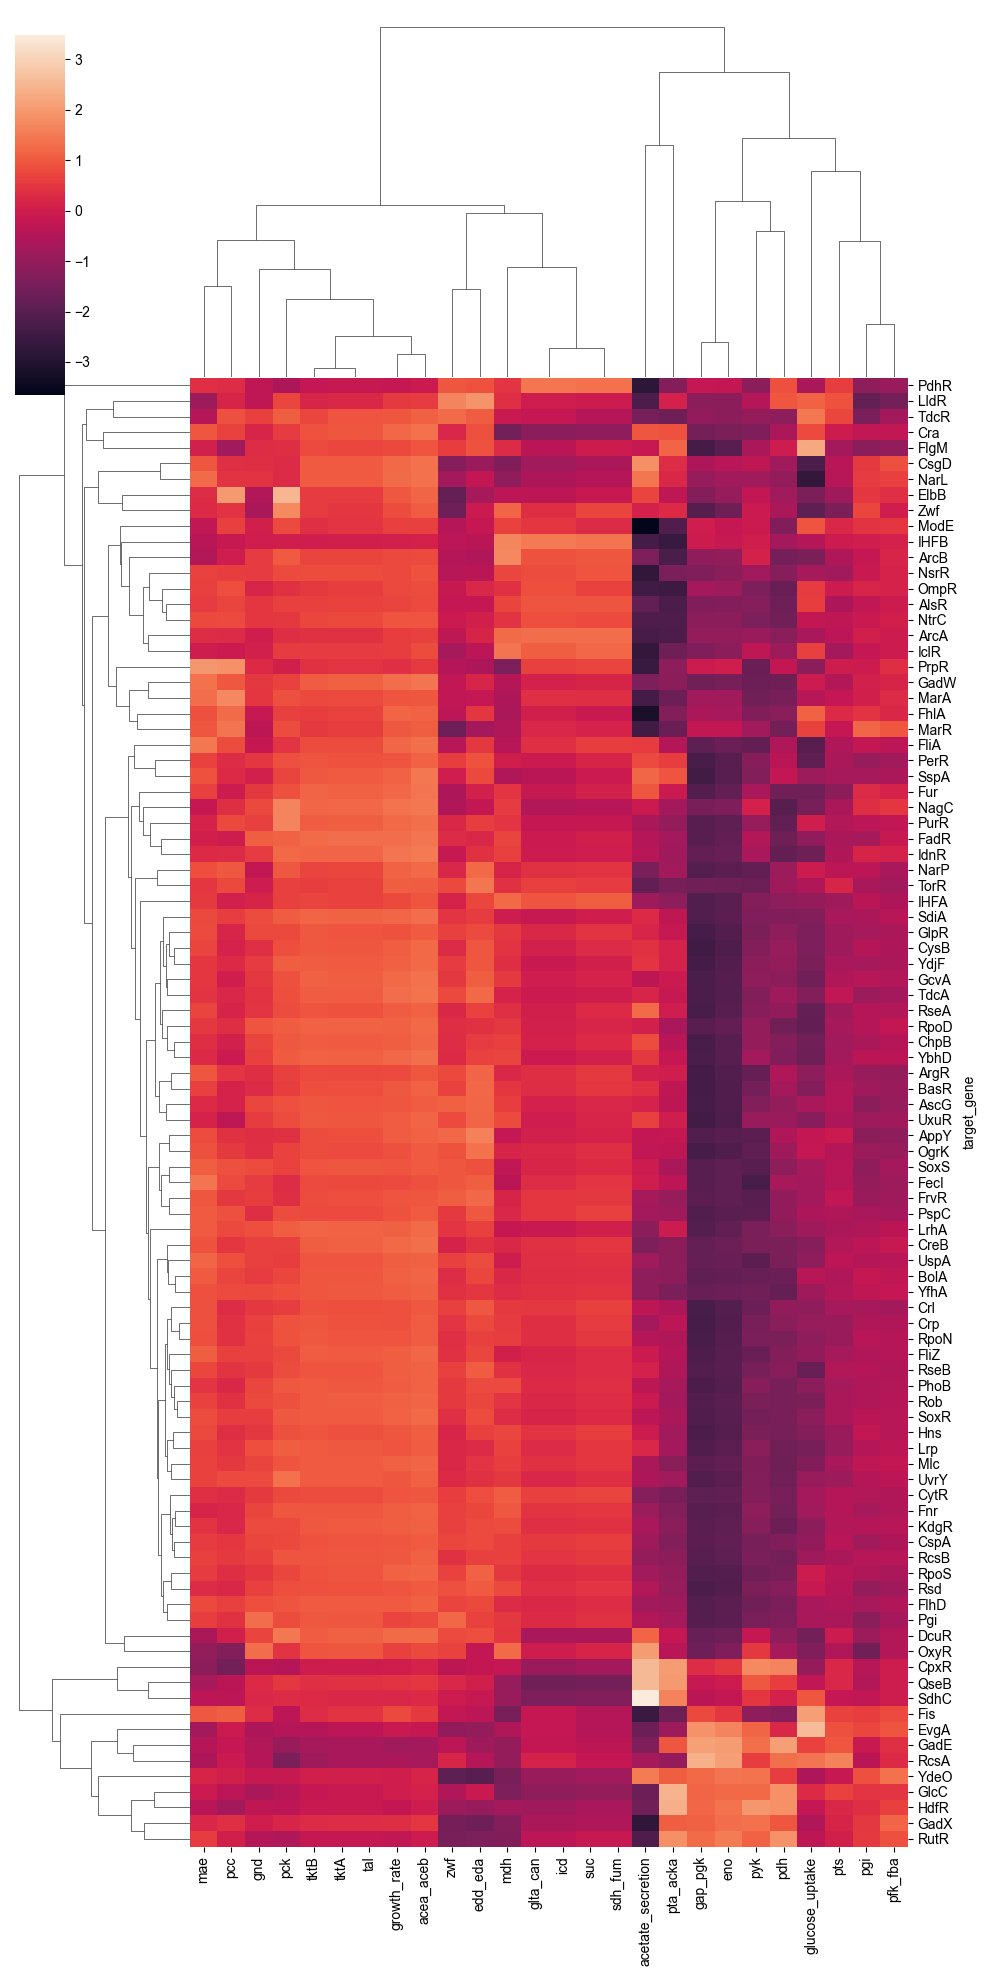

In [3]:
plt.close('all')
clustergrid = sns.clustermap(all_data_norm, z_score=0, figsize=(10,20), yticklabels=True)
ordered_fluxes_indices = clustergrid.dendrogram_col.reordered_ind
ordered_genes_indices = clustergrid.dendrogram_row.reordered_ind
sns.set_theme(palette="colorblind")
plt.show()

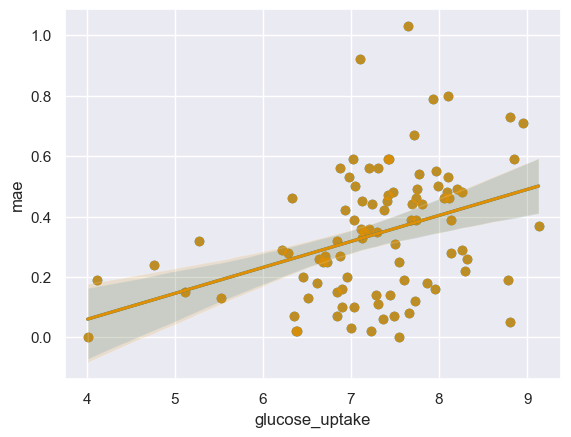

In [9]:
sns.regplot(data=all_data, x="glucose_uptake", y="mae")
plt.show()

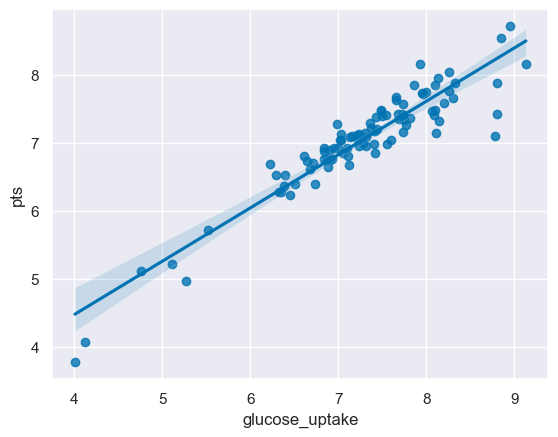

In [11]:
sns.regplot(data=all_data, x="glucose_uptake", y="pts")
plt.show()

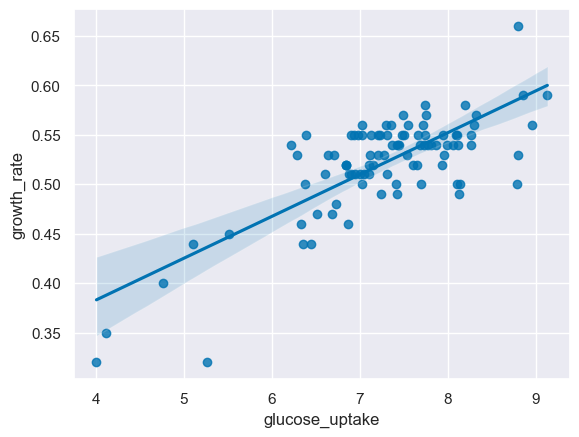

In [13]:
sns.regplot(data=all_data, x="glucose_uptake", y="growth_rate")
plt.show()

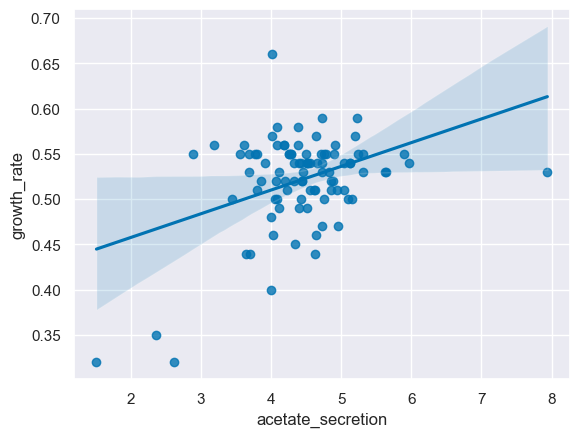

In [14]:
sns.regplot(data=all_data, x="acetate_secretion", y="growth_rate")
plt.show()

(94, 94)


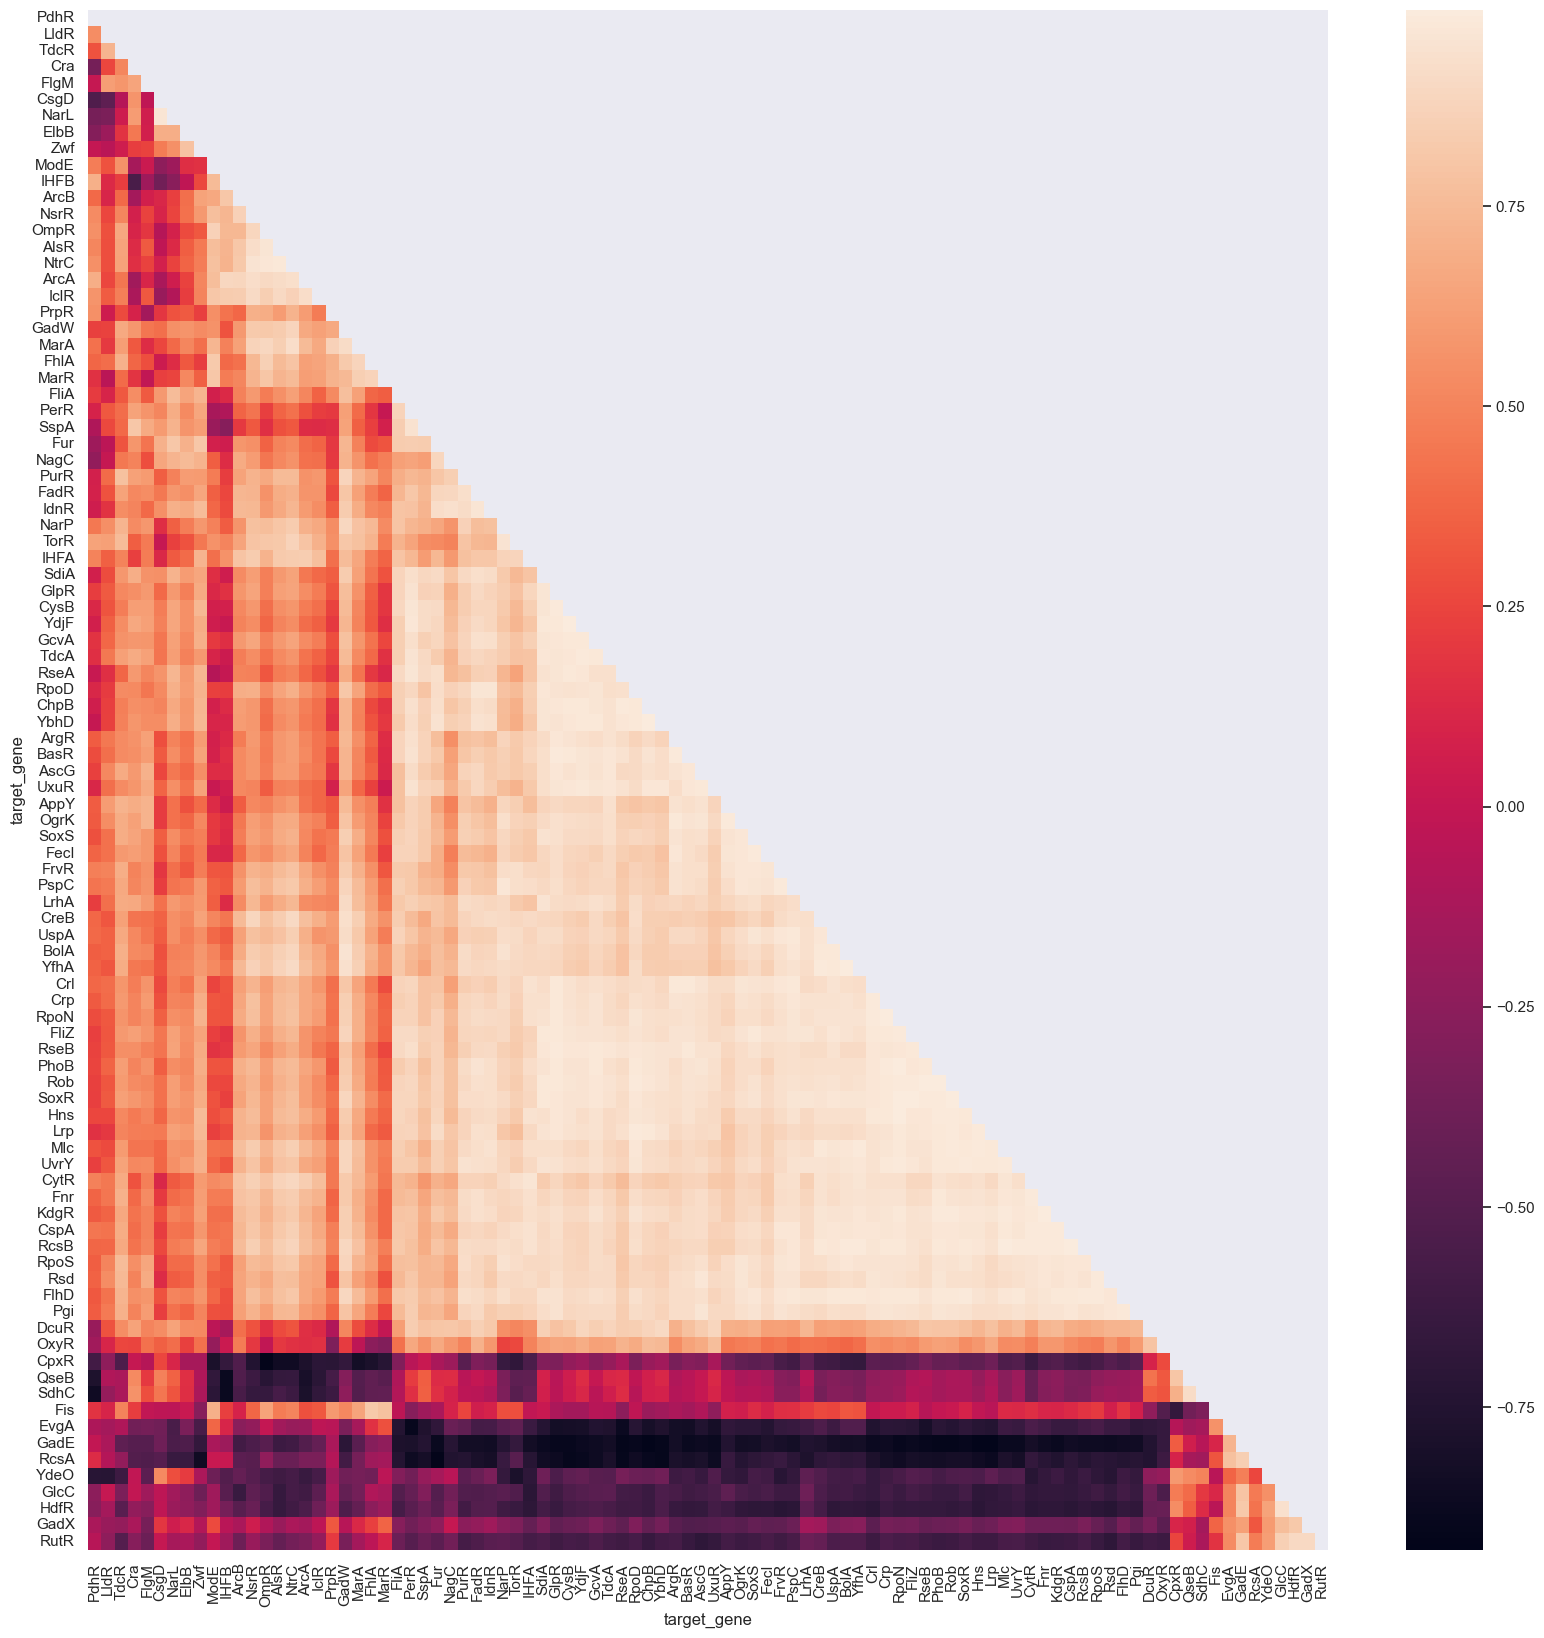

In [18]:
corr_mat_genes = all_data_norm.iloc[ordered_genes_indices].T.corr()
mask = np.triu(np.ones_like(all_data_norm.T.corr()))
print(mask.shape)
fig, ax = plt.subplots(figsize=(20, 20))
g = sns.heatmap(corr_mat_genes, xticklabels=all_data_norm.index[ordered_genes_indices], yticklabels=all_data_norm.index[ordered_genes_indices], mask=mask)
sns.set_theme(palette="colorblind")
plt.show()

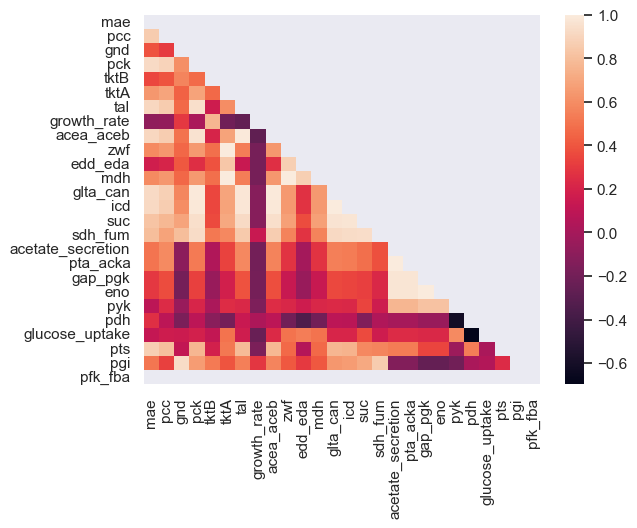

In [19]:
plt.close('all')
corr_mat_fluxes = all_data_norm.iloc[ordered_fluxes_indices].corr()
mask = np.triu(np.ones_like(corr_mat_fluxes))
sns.heatmap(corr_mat_fluxes, xticklabels=all_data.columns[ordered_fluxes_indices], yticklabels=all_data.columns[ordered_fluxes_indices], mask=mask)
sns.set_theme(palette="colorblind")
plt.show()